To summarize the content of this Notebook:
1. Getting data from Spotify using Spotify Web API
2. Data analysis
3. Feature selection
4. Clustering songs using K-Means (and choosing 'k' with the 'Elbow Method')
5. Visualizing these clusters using PCA and t-SNE
6. Insights about each cluster 
7. Using SMOTE to balance data
8. Predicting, with SVM, each songs' cluster

In [2]:
import spotipy #Python library for the Spotify Web API
import seaborn as sns #data visualization
import matplotlib.pyplot as plt #data visualization
import numpy as np #linear algebra
import pandas as pd #data processing 

In [3]:
#Authentication
from spotipy.oauth2 import SpotifyClientCredentials

#spotify object to access API
# spotify = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, client_id='582a7ae4bd534e93ba02c6fba4e7eea3',
#                                                    client_secret='43fdeb78520142d1899bc49506e1aa26',
#                                                    redirect_uri='http://localhost:1410/'))
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials('582a7ae4bd534e93ba02c6fba4e7eea3', 
                                                                             '43fdeb78520142d1899bc49506e1aa26'))

In [108]:
user = '12167283276' #your own username here
playlists = spotify.user_playlists(user) 
print(type(playlists))

for key in playlists:
    print(key)
    
print('\n')
while playlists:
    for i, playlist in enumerate(playlists['items']):
        print("%s - %s" % (playlist['uri'],  playlist['name']))
    if playlists['next']:
        playlists = spotify.next(playlists)
    else:
        break

<class 'dict'>
href
items
limit
next
offset
previous
total


spotify:playlist:5C0NiJuagtVDlROPBTSe6X - Hits 2015-2022
spotify:playlist:3aTZaJoWdq9yicp9HO76i7 - TOP Hits of 2017, 2018, 2019, 2020, 2021 + Few more
spotify:playlist:1bjAgktyYGqKJXynU4H8SO - 2021 Billboard Year End Top 100
spotify:playlist:1WBljFutuk7uLQtfqfmjWV - Billboard 2020 Year End Hot 100
spotify:playlist:6sxay2eKIKLxHCuytNSohv - 2019 Billboard Year End Hot 100
spotify:playlist:1kyCPXLTaawIQiGAyDuZ15 - 21to19
spotify:playlist:6pxE2LNjmUt16fV3vBLZ8b - songs2021
spotify:playlist:1GmtdvPoL5xPtVOm7TuMkV - songs2020
spotify:playlist:6ESrXdavo4TM2yoItrgwjV - songs2019
spotify:playlist:5DzrjN5gP1vMbkb78rtsjO - Trucker
spotify:playlist:60TiwliXOThwhpFe3N8XMB - Dirty
spotify:playlist:3SR3bfNSCTHPHGXvvR0Osk - Trail
spotify:playlist:5Ao3MDcveD5rHPHxtZfVdL - High
spotify:playlist:3HDsMDnTk7RecYyOLRcTCp - Rini
spotify:playlist:4JiM8eHAmwi9GsxgAXFuyY - Morning
spotify:playlist:4ZbV8ywYAy8xMkRblHoRZW - Tattoo
spotify:playlist:6brUJ

In [132]:
chosen_playlist1 = '6sxay2eKIKLxHCuytNSohv' #your own playlist id here
chosen_playlist2 = '1WBljFutuk7uLQtfqfmjWV'
chosen_playlist3 = '1bjAgktyYGqKJXynU4H8SO'

tracks_pt1 = spotify.user_playlist_tracks(user, chosen_playlist1, limit=100, offset=0)
#print(tracks_pt1)
tracks_pt2 = spotify.user_playlist_tracks(user, chosen_playlist2, limit=100, offset=0)
#print(tracks_pt2)
tracks_pt3 = spotify.user_playlist_tracks(user, chosen_playlist3, limit=100, offset=0)
#print(tracks_pt3)
tracklist = tracks_pt1['items'] + tracks_pt2['items'] + tracks_pt3['items']
#print(tracklist)

#Creating data frame with the information from the chosen playlist
data = pd.DataFrame(tracklist)
#print(data)

In [133]:
data.columns

Index(['added_at', 'added_by', 'is_local', 'primary_color', 'track',
       'video_thumbnail'],
      dtype='object')

In [134]:
data.iloc[:,4].describe

<bound method NDFrame.describe of 0      {'album': {'album_type': 'single', 'artists': ...
1      {'album': {'album_type': 'compilation', 'artis...
2      {'album': {'album_type': 'single', 'artists': ...
3      {'album': {'album_type': 'album', 'artists': [...
4      {'album': {'album_type': 'single', 'artists': ...
                             ...                        
295    {'album': {'album_type': 'album', 'artists': [...
296    {'album': {'album_type': 'single', 'artists': ...
297    {'album': {'album_type': 'album', 'artists': [...
298    {'album': {'album_type': 'single', 'artists': ...
299    {'album': {'album_type': 'single', 'artists': ...
Name: track, Length: 300, dtype: object>

In [135]:
playlist_info = []
for k,v in enumerate(tracklist):
    info = v['track']
    #print(info)
    #print("\n\n\n\n\n\n")
    
    playlist_info.append((info['name'], info['artists'][0]['name'], info['album']['name'], info['album']['id'], info['album']['release_date'][:4]))

print(playlist_info)

[('Old Town Road (feat. Billy Ray Cyrus) - Remix', 'Lil Nas X', 'Old Town Road', '38kpkGLuPr1nNfD3iEyOlJ', '2019'), ('Sunflower - Spider-Man: Into the Spider-Verse', 'Post Malone', 'Spider-Man: Into the Spider-Verse (Soundtrack From & Inspired by the Motion Picture)', '35s58BRTGAEWztPo9WqCIs', '2018'), ('Without Me', 'Halsey', 'Without Me', '0zzrCTzvL4ZmR42xF46Afm', '2018'), ('bad guy', 'Billie Eilish', 'WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?', '0S0KGZnfBGSIssfF54WSJh', '2019'), ('Wow.', 'Post Malone', 'Wow.', '5Dcz8PZHKuvTyjbqEPL5VM', '2018'), ('Happier', 'Marshmello', 'Happier', '78EicdHZr5XBWD7llEZ1Jh', '2018'), ('7 rings', 'Ariana Grande', '7 rings', '03D36t8ODrA8ATvoTStU9P', '2019'), ('Talk (feat. Disclosure)', 'Khalid', 'Free Spirit', '6KT8x5oqZJl9CcnM66hddo', '2019'), ('SICKO MODE', 'Travis Scott', 'ASTROWORLD', '41GuZcammIkupMPKH2OJ6I', '2018'), ('Sucker', 'Jonas Brothers', 'Sucker', '4W0r9HOcuCC6Vh7aze2hwi', '2019'), ('High Hopes', 'Panic! At The Disco', 'Pray for the Wicked

In [136]:
playlist_df = pd.DataFrame(playlist_info, columns=('Song', 'Artist', 'Album', 'Id', 'year'))
playlist_df.head(300)

,Song,Artist,Album,Id,year
0,Old Town Road (feat. Billy Ray Cyrus) - Remix,Lil Nas X,Old Town Road,38kpkGLuPr1nNfD3iEyOlJ,2019
1,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Spider-Man: Into the Spider-Verse (Soundtrack ...,35s58BRTGAEWztPo9WqCIs,2018
2,Without Me,Halsey,Without Me,0zzrCTzvL4ZmR42xF46Afm,2018
3,bad guy,Billie Eilish,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",0S0KGZnfBGSIssfF54WSJh,2019
4,Wow.,Post Malone,Wow.,5Dcz8PZHKuvTyjbqEPL5VM,2018
...,...,...,...,...,...
295,Things A Man Oughta Know,Lainey Wilson,Sayin' What I'm Thinkin',3I0SEplNpqsPfnLVZsNPif,2021
296,Throat Baby (Go Baby),BRS Kash,Throat Baby (Go Baby),6SVYokMycYHjHNfAL1rfJV,2020
297,Tombstone,Rod Wave,SoulFly,7q5xGp0tEnJ8s1ZumqiRSk,2021
298,Drinkin' Beer. Talkin' God. Amen. (feat. Flori...,Chase Rice,Drinkin' Beer. Talkin' God. Amen. (feat. Flori...,5H6lxubLtZamdoXEmVmcbz,2020


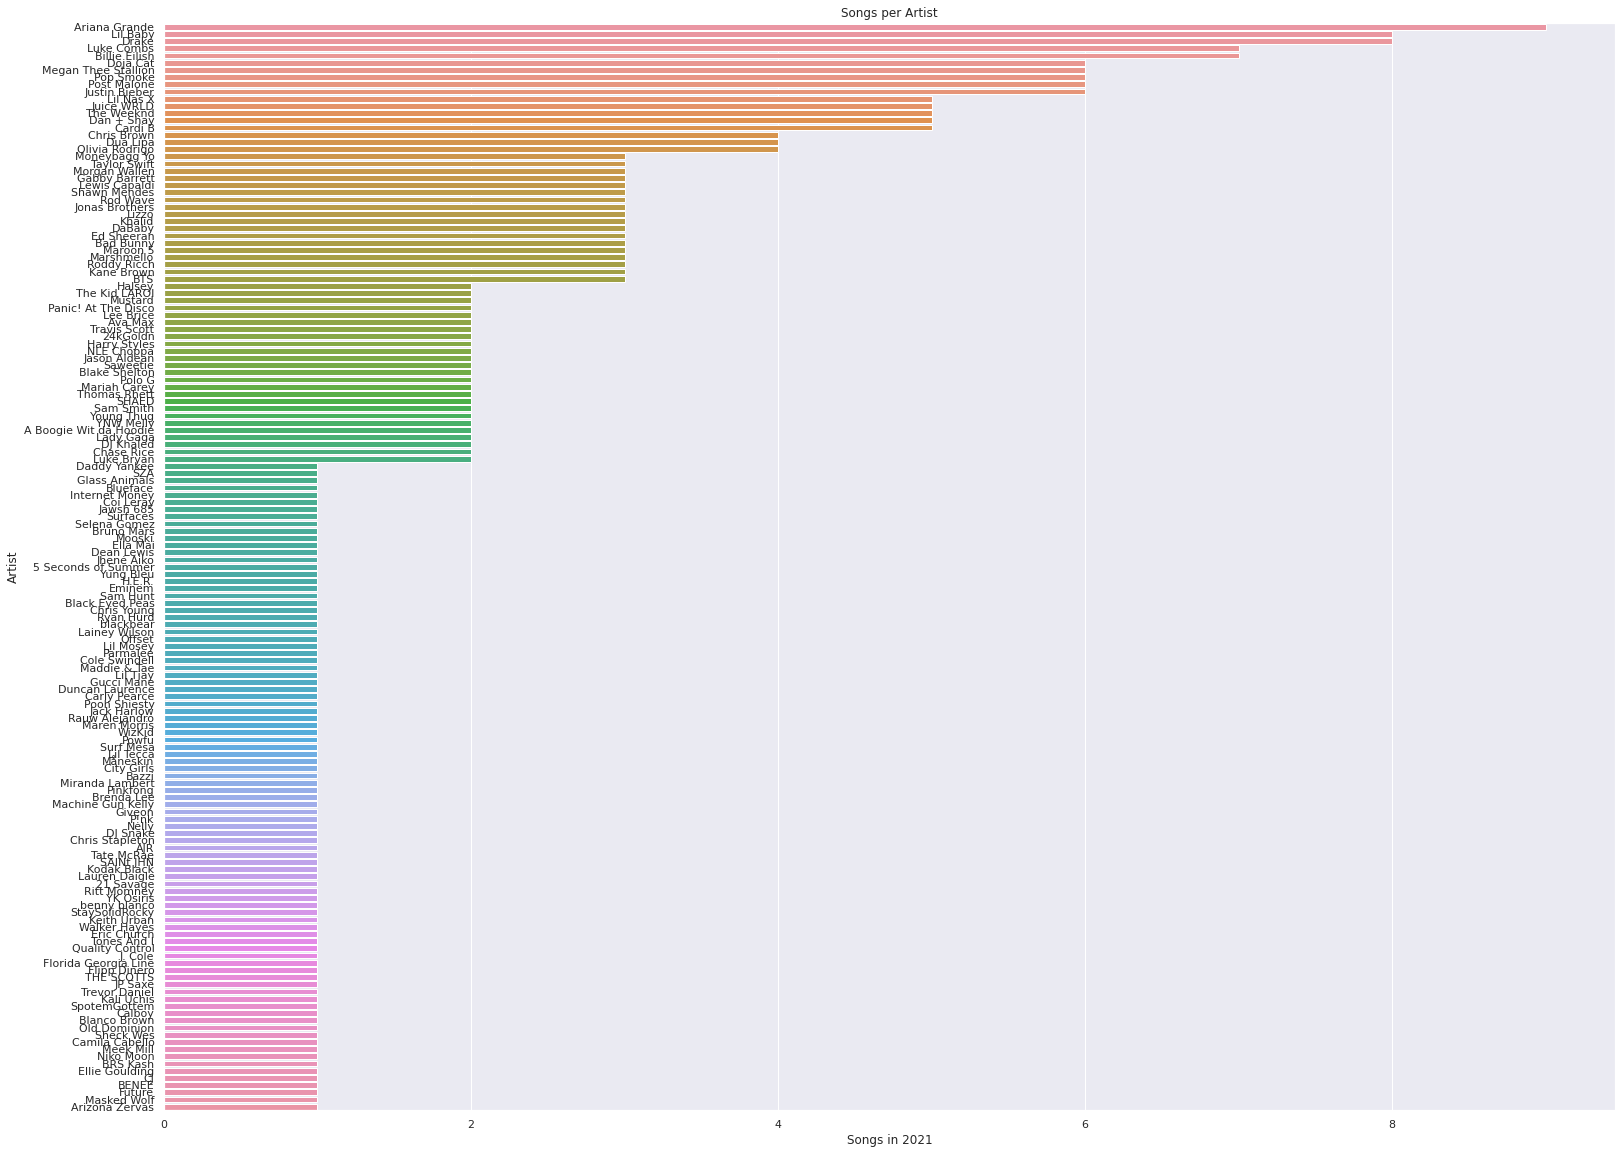

In [137]:
fav_artists = playlist_df['Artist'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(y=playlist_df['Artist'], order=fav_artists)
plt.xlabel('Songs in 2021')
plt.title('Songs per Artist')
sns.set(rc={'figure.figsize':(26,20)})

Text(0.5, 1.0, 'Songs per Album in 2021')

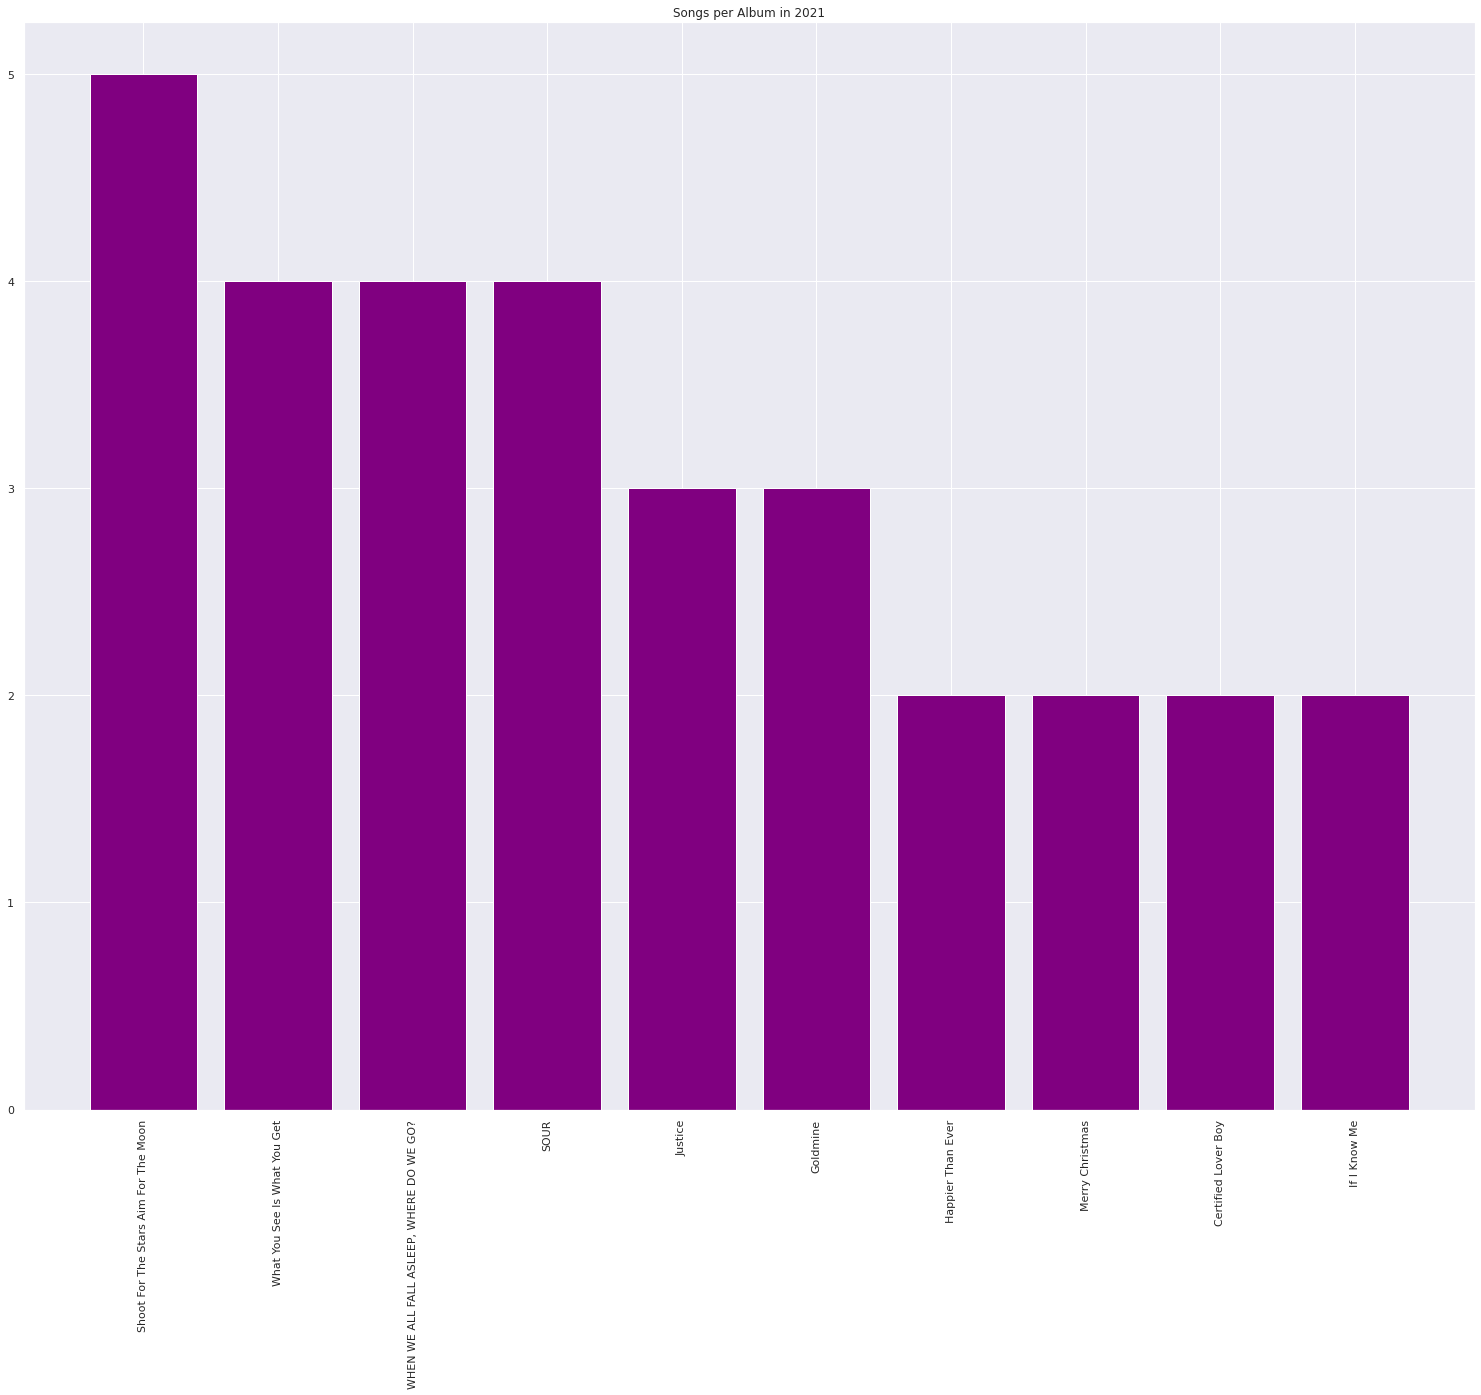

In [138]:
ax = plt.bar(playlist_df['Album'].value_counts().head(10).keys(), playlist_df['Album'].value_counts().head(10),
            color='purple')
plt.xticks(rotation=90)
plt.title('Songs per Album in 2021')

In [139]:
#Grabbing audio features for each song
audio_features_names = []
audio_features_ids = []
audio_features_artists = []
audio_features_years = []
#Iterating over 'tracklist' in order to create some lists which will be on our audio features data frame
for k,v in enumerate(tracklist):
    info = v['track']
    audio_features_names.append(info['name'])
    audio_features_ids.append(info['id'])
    audio_features_artists.append(info['artists'][0]['name'])
    audio_features_years.append(info['album']['release_date'][:4])
    
audio_features_pt1 = []
audio_features_pt2 = []
audio_features_pt3 = []
audio_features_pt4 = []
audio_features_pt5 = []
audio_features_pt6 = []
for i in range(len(audio_features_ids)):
    print(i)
    if i < 50:
        audio_features_pt1.append(audio_features_ids[i])
    elif i < 100:
        audio_features_pt2.append(audio_features_ids[i])
    elif i < 150:
        audio_features_pt3.append(audio_features_ids[i])
    elif i < 200:
        audio_features_pt4.append(audio_features_ids[i])
    elif i < 250:
        audio_features_pt5.append(audio_features_ids[i])
    elif i < 300:
        audio_features_pt6.append(audio_features_ids[i])



#Get audio features for one or multiple tracks based upon their Spotify IDs: audio_features(tracks=[])
#tracks - a list of track URIs, URLs or IDs, maximum: 50 ids
audio_features1 = spotify.audio_features(audio_features_pt1)
audio_features2 = spotify.audio_features(audio_features_pt2)
audio_features3 = spotify.audio_features(audio_features_pt3)
audio_features4 = spotify.audio_features(audio_features_pt4)
audio_features5 = spotify.audio_features(audio_features_pt5)
audio_features6 = spotify.audio_features(audio_features_pt6)

audio_features = audio_features1+audio_features2+audio_features3+audio_features4+audio_features5+audio_features6
#audio_features = audio_features1
audio_features

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[{'danceability': 0.878,
  'energy': 0.619,
  'key': 6,
  'loudness': -5.56,
  'mode': 1,
  'speechiness': 0.102,
  'acousticness': 0.0533,
  'instrumentalness': 0,
  'liveness': 0.113,
  'valence': 0.639,
  'tempo': 136.041,
  'type': 'audio_features',
  'id': '6u7jPi22kF8CTQ3rb9DHE7',
  'uri': 'spotify:track:6u7jPi22kF8CTQ3rb9DHE7',
  'track_href': 'https://api.spotify.com/v1/tracks/6u7jPi22kF8CTQ3rb9DHE7',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6u7jPi22kF8CTQ3rb9DHE7',
  'duration_ms': 157067,
  'time_signature': 4},
 {'danceability': 0.76,
  'energy': 0.479,
  'key': 2,
  'loudness': -5.574,
  'mode': 1,
  'speechiness': 0.0466,
  'acousticness': 0.556,
  'instrumentalness': 0,
  'liveness': 0.0703,
  'valence': 0.913,
  'tempo': 89.911,
  'type': 'audio_features',
  'id': '3KkXRkHbMCARz0aVfEt68P',
  'uri': 'spotify:track:3KkXRkHbMCARz0aVfEt68P',
  'track_href': 'https://api.spotify.com/v1/tracks/3KkXRkHbMCARz0aVfEt68P',
  'analysis_url': 'https://api.spotify.

In [140]:
#Creating audio features data frame
audio_features_df = pd.DataFrame(audio_features) 

audio_features_df.insert(0, "track", audio_features_names, True) #using insert() to add a column to our data frame
audio_features_df.insert(1, "artist", audio_features_artists, True)
audio_features_df.insert(2, "year", audio_features_years, True)
audio_features_df.head(30)
#audio_features_df.to_csv("audFeatures2019.csv")
# audio_features_df = pd.read_csv("audFeatCSV.csv") 
# audio_features_df.head(30)

,track,artist,year,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Old Town Road (feat. Billy Ray Cyrus) - Remix,Lil Nas X,2019,0.878,0.619,6,-5.560,1,0.1020,0.05330,...,0.1130,0.639,136.041,audio_features,6u7jPi22kF8CTQ3rb9DHE7,spotify:track:6u7jPi22kF8CTQ3rb9DHE7,https://api.spotify.com/v1/tracks/6u7jPi22kF8C...,https://api.spotify.com/v1/audio-analysis/6u7j...,157067,4
1,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,2018,0.760,0.479,2,-5.574,1,0.0466,0.55600,...,0.0703,0.913,89.911,audio_features,3KkXRkHbMCARz0aVfEt68P,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,158040,4
2,Without Me,Halsey,2018,0.752,0.488,6,-7.050,1,0.0705,0.29700,...,0.0936,0.533,136.041,audio_features,5p7ujcrUXASCNwRaWNHR1C,spotify:track:5p7ujcrUXASCNwRaWNHR1C,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,https://api.spotify.com/v1/audio-analysis/5p7u...,201661,4
3,bad guy,Billie Eilish,2019,0.701,0.425,7,-10.965,1,0.3750,0.32800,...,0.1000,0.562,135.128,audio_features,2Fxmhks0bxGSBdJ92vM42m,spotify:track:2Fxmhks0bxGSBdJ92vM42m,https://api.spotify.com/v1/tracks/2Fxmhks0bxGS...,https://api.spotify.com/v1/audio-analysis/2Fxm...,194088,4
4,Wow.,Post Malone,2018,0.833,0.539,11,-7.399,0,0.1780,0.16300,...,0.1010,0.385,99.947,audio_features,6MWtB6iiXyIwun0YzU6DFP,spotify:track:6MWtB6iiXyIwun0YzU6DFP,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,https://api.spotify.com/v1/audio-analysis/6MWt...,149520,4
5,Happier,Marshmello,2018,0.687,0.792,5,-2.749,1,0.0452,0.19100,...,0.1670,0.671,100.015,audio_features,2dpaYNEQHiRxtZbfNsse99,spotify:track:2dpaYNEQHiRxtZbfNsse99,https://api.spotify.com/v1/tracks/2dpaYNEQHiRx...,https://api.spotify.com/v1/audio-analysis/2dpa...,214290,4
6,7 rings,Ariana Grande,2019,0.725,0.321,1,-10.744,0,0.3230,0.57800,...,0.0884,0.319,70.142,audio_features,14msK75pk3pA33pzPVNtBF,spotify:track:14msK75pk3pA33pzPVNtBF,https://api.spotify.com/v1/tracks/14msK75pk3pA...,https://api.spotify.com/v1/audio-analysis/14ms...,178640,4
7,Talk (feat. Disclosure),Khalid,2019,0.900,0.400,0,-8.575,1,0.1270,0.05160,...,0.0599,0.346,135.984,audio_features,6TqXcAFInzjp0bODyvrWEq,spotify:track:6TqXcAFInzjp0bODyvrWEq,https://api.spotify.com/v1/tracks/6TqXcAFInzjp...,https://api.spotify.com/v1/audio-analysis/6TqX...,197573,4
8,SICKO MODE,Travis Scott,2018,0.834,0.730,8,-3.714,1,0.2220,0.00513,...,0.1240,0.446,155.008,audio_features,2xLMifQCjDGFmkHkpNLD9h,spotify:track:2xLMifQCjDGFmkHkpNLD9h,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,https://api.spotify.com/v1/audio-analysis/2xLM...,312820,4
9,Sucker,Jonas Brothers,2019,0.842,0.734,1,-5.065,0,0.0588,0.04270,...,0.1060,0.952,137.958,audio_features,4y3OI86AEP6PQoDE6olYhO,spotify:track:4y3OI86AEP6PQoDE6olYhO,https://api.spotify.com/v1/tracks/4y3OI86AEP6P...,https://api.spotify.com/v1/audio-analysis/4y3O...,181040,4


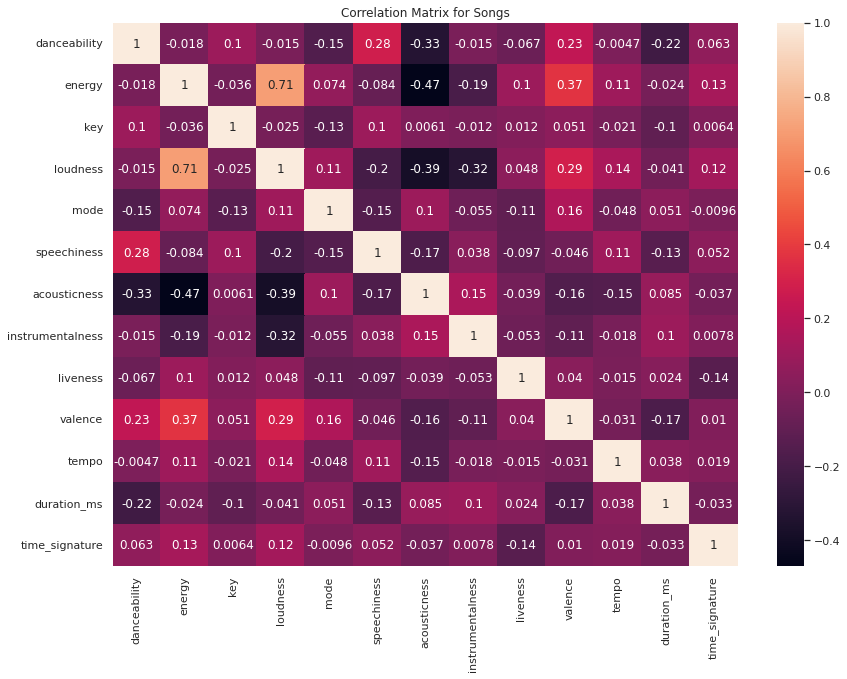

In [141]:
#Feature analysis
correlation_matrix = audio_features_df.corr()
ax = plt.subplots(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True) #annot: if True, write the data value in each cell.
plt.title('Correlation Matrix for Songs')
plt.show()

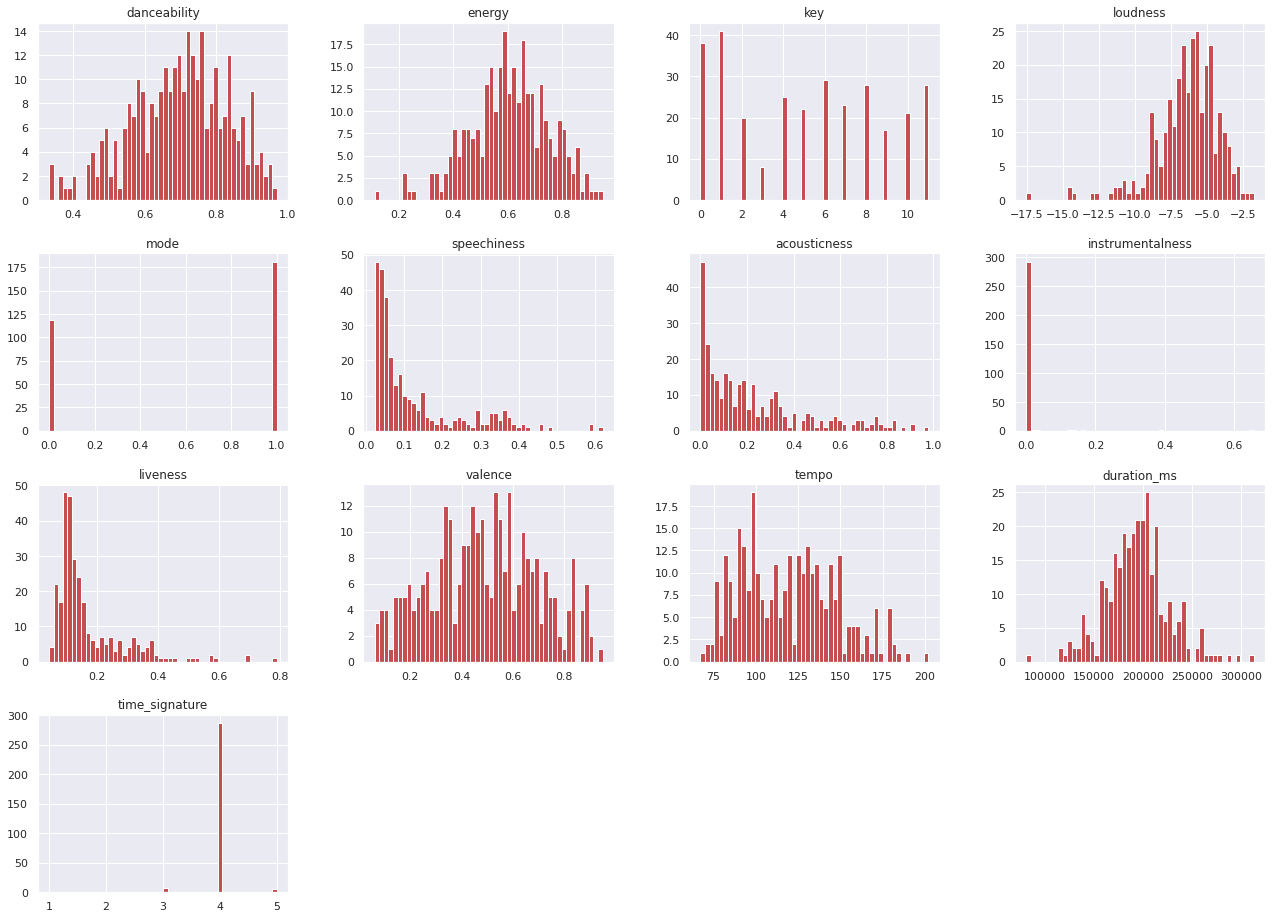

In [142]:
audio_features_df.hist(bins=50, figsize=(22,16), color='r')
plt.title('Features of Songs')
plt.show()

In [143]:
#Chosen features (after analyzing both the heatmap and histogram above)
features = ['energy', 'danceability', 'liveness', 'valence',  'instrumentalness', 'acousticness']

audio_features_df.loc[:, features].mean()

energy              0.606357
danceability        0.695097
liveness            0.168415
valence             0.486168
instrumentalness    0.005698
acousticness        0.229226
dtype: float64

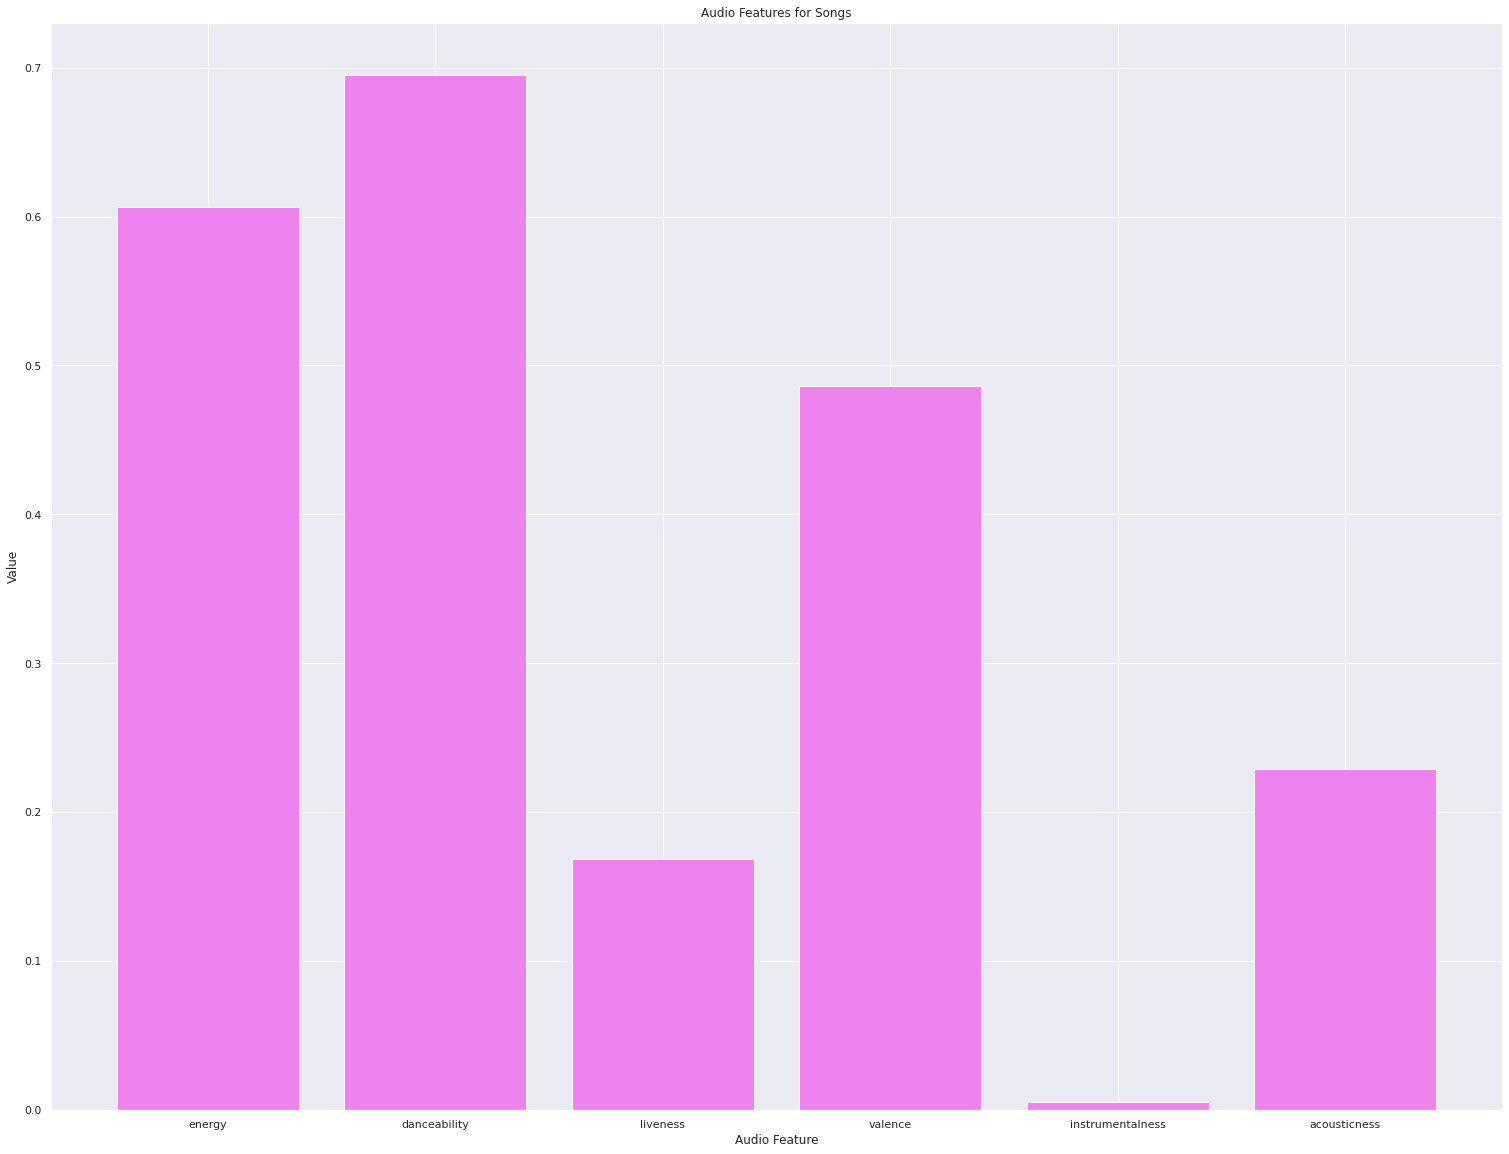

In [144]:
ax = plt.bar(audio_features_df.loc[:, features].mean().keys(), audio_features_df.loc[:, features].mean(), 
             color='violet')
plt.xlabel('Audio Feature')
plt.ylabel('Value')
plt.title('Audio Features for Songs')
plt.show()

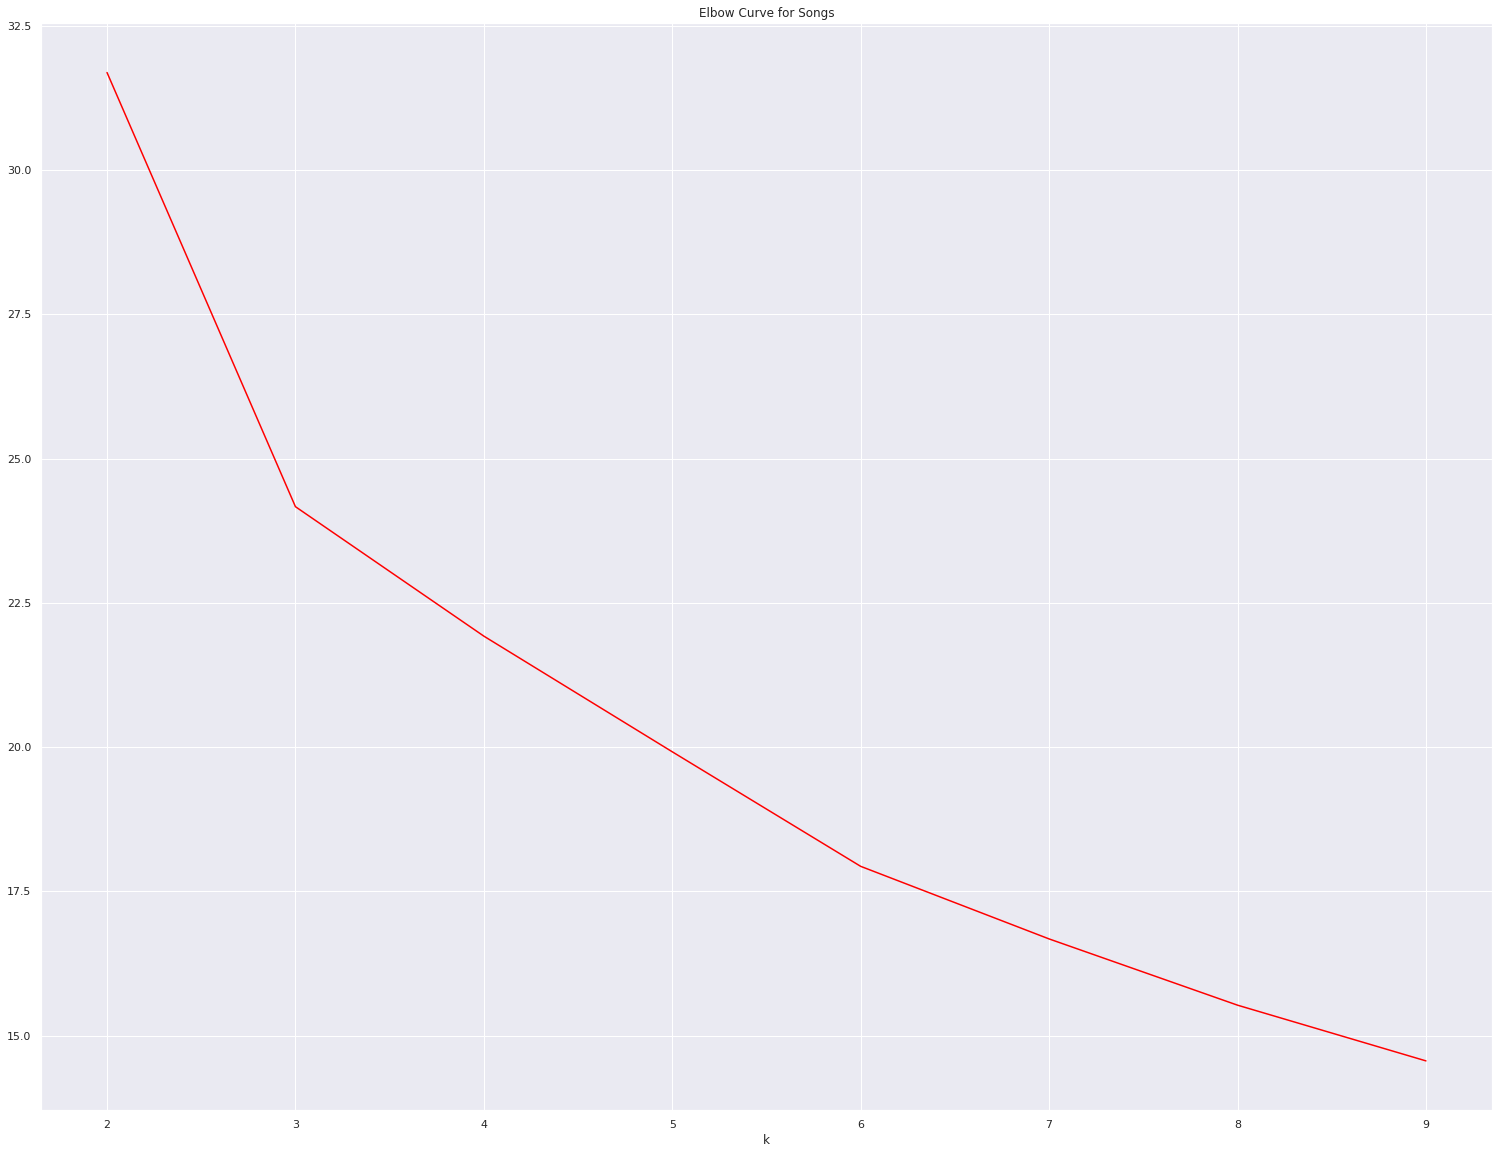

In [145]:
#Clustering songs
from sklearn.cluster import KMeans

#In order to cluster the songs, we are going to use KMeans algorithm, which finds a certain (predefined) 'k'
#number of clusters (group of data points that are grouped together due to similarities in their features) 
#in a set of data
#We are going to use the 'Elbow method' to find an optimal number of clusters 'k'
X = audio_features_df[features]
distorsions = []
for k in range(2,10):
    model = KMeans(n_clusters=k)
    model.fit(X)
    distorsions.append(model.inertia_)

plt.plot(range(2,10), distorsions, color='red')
plt.grid(True)
plt.xlabel('k')
plt.title('Elbow Curve for Songs')
plt.show()

In [161]:
#Training data
X = audio_features_df[features]
model = KMeans(n_clusters=3)
model.fit(X)

y = model.predict(X) #Each song goes to the cluster which has the most similarities in their features
y

array([0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 2, 2, 1,
       0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       2, 1, 2, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0,
       1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2,
       2, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 1,
       0, 2, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 1, 0, 0,
       2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 0,
       2, 1, 0, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 2,
       0, 2, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 1, 0, 2,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 0, 1, 2, 2, 0, 2,
       0, 1, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 1, 0, 2, 2, 1, 1, 0, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 0, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0,
       1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2, 2,
       2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 1, 0, 2], d

In [162]:
centers = model.cluster_centers_
centers

array([[0.68654622, 0.73385714, 0.17700084, 0.6872605 , 0.00148123,
        0.14255712],
       [0.48137037, 0.60859259, 0.1605537 , 0.38428889, 0.01530312,
        0.63538889],
       [0.5843622 , 0.69555906, 0.1637126 , 0.34106063, 0.00556492,
        0.13773651]])

/home/shubham/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shubham/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


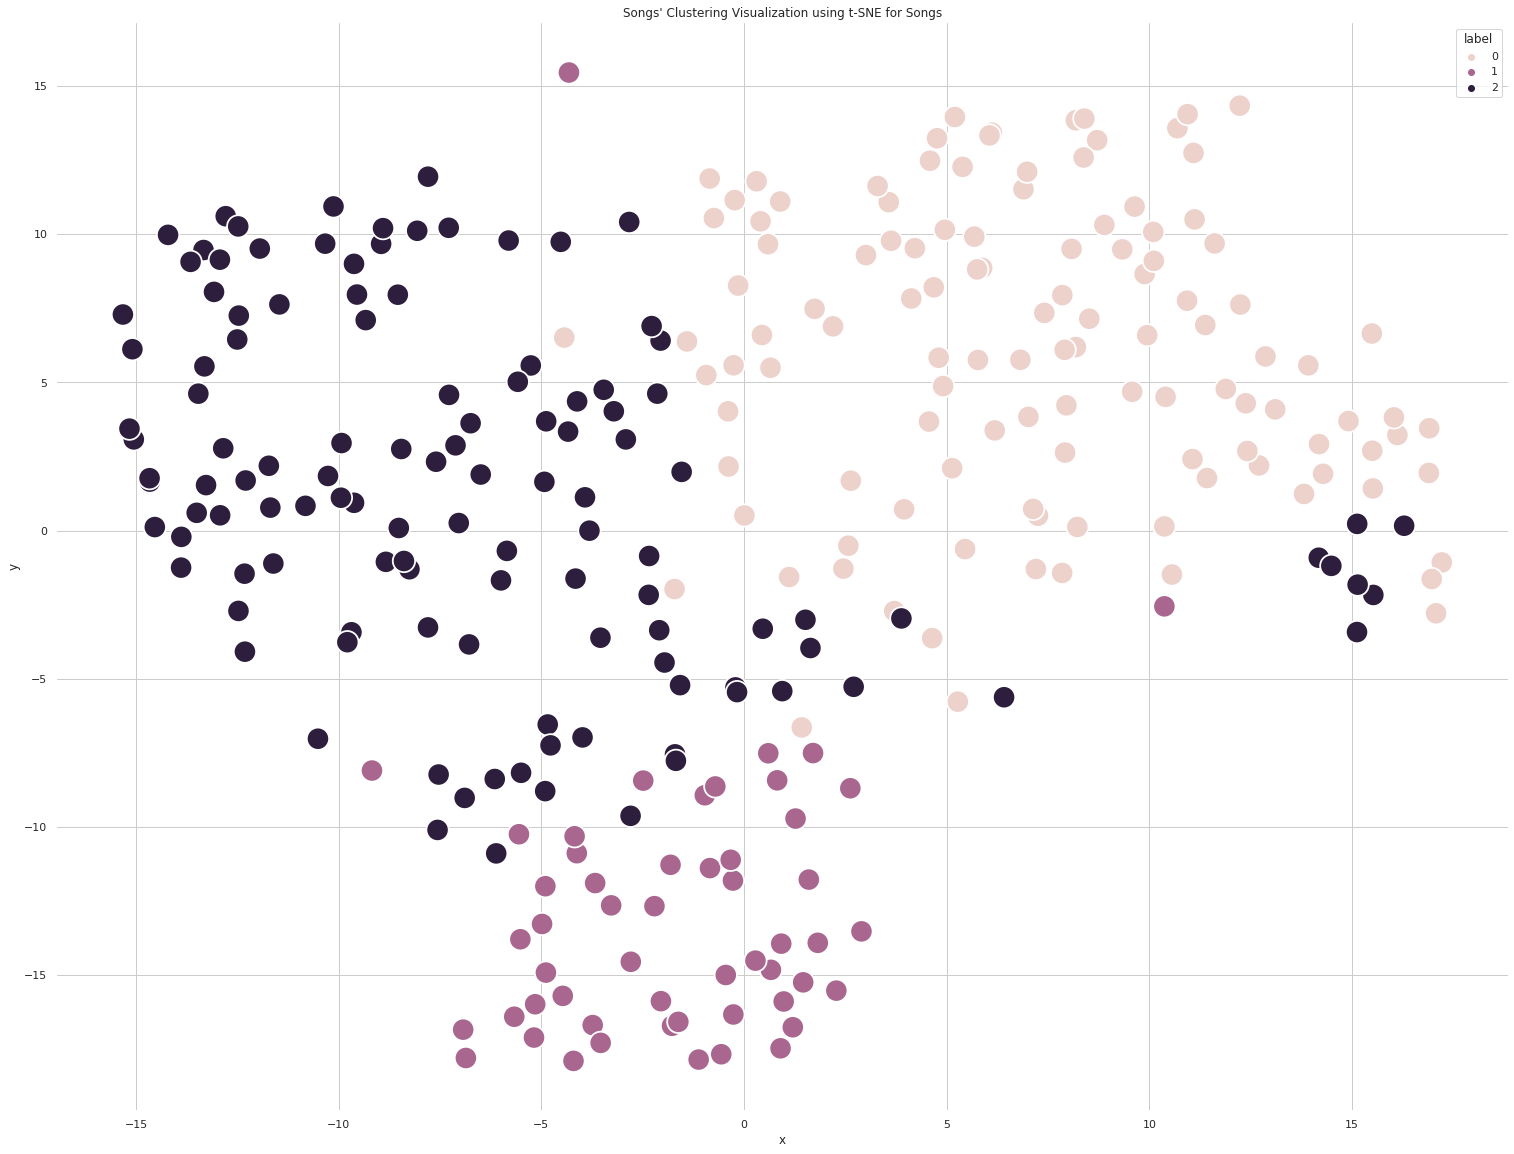

In [163]:
#Since we are working with 6 features, we are going to apply dimensionality reduction techniques in order 
#to visualize our data in 2d. We are going to test PCA and t-SNE algorithms
#t-SNE seeks to preserve small pairwise distances 

from sklearn.manifold import TSNE

tsne_obj = TSNE()
tsne = tsne_obj.fit_transform(X)

tsne_df = pd.DataFrame(tsne, columns=['x', 'y'])
tsne_df['label'] = y

sns.set_style("whitegrid")
sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', s=500)
sns.despine(left=True, bottom=True)
plt.title("Songs' Clustering Visualization using t-SNE for Songs")
plt.show()

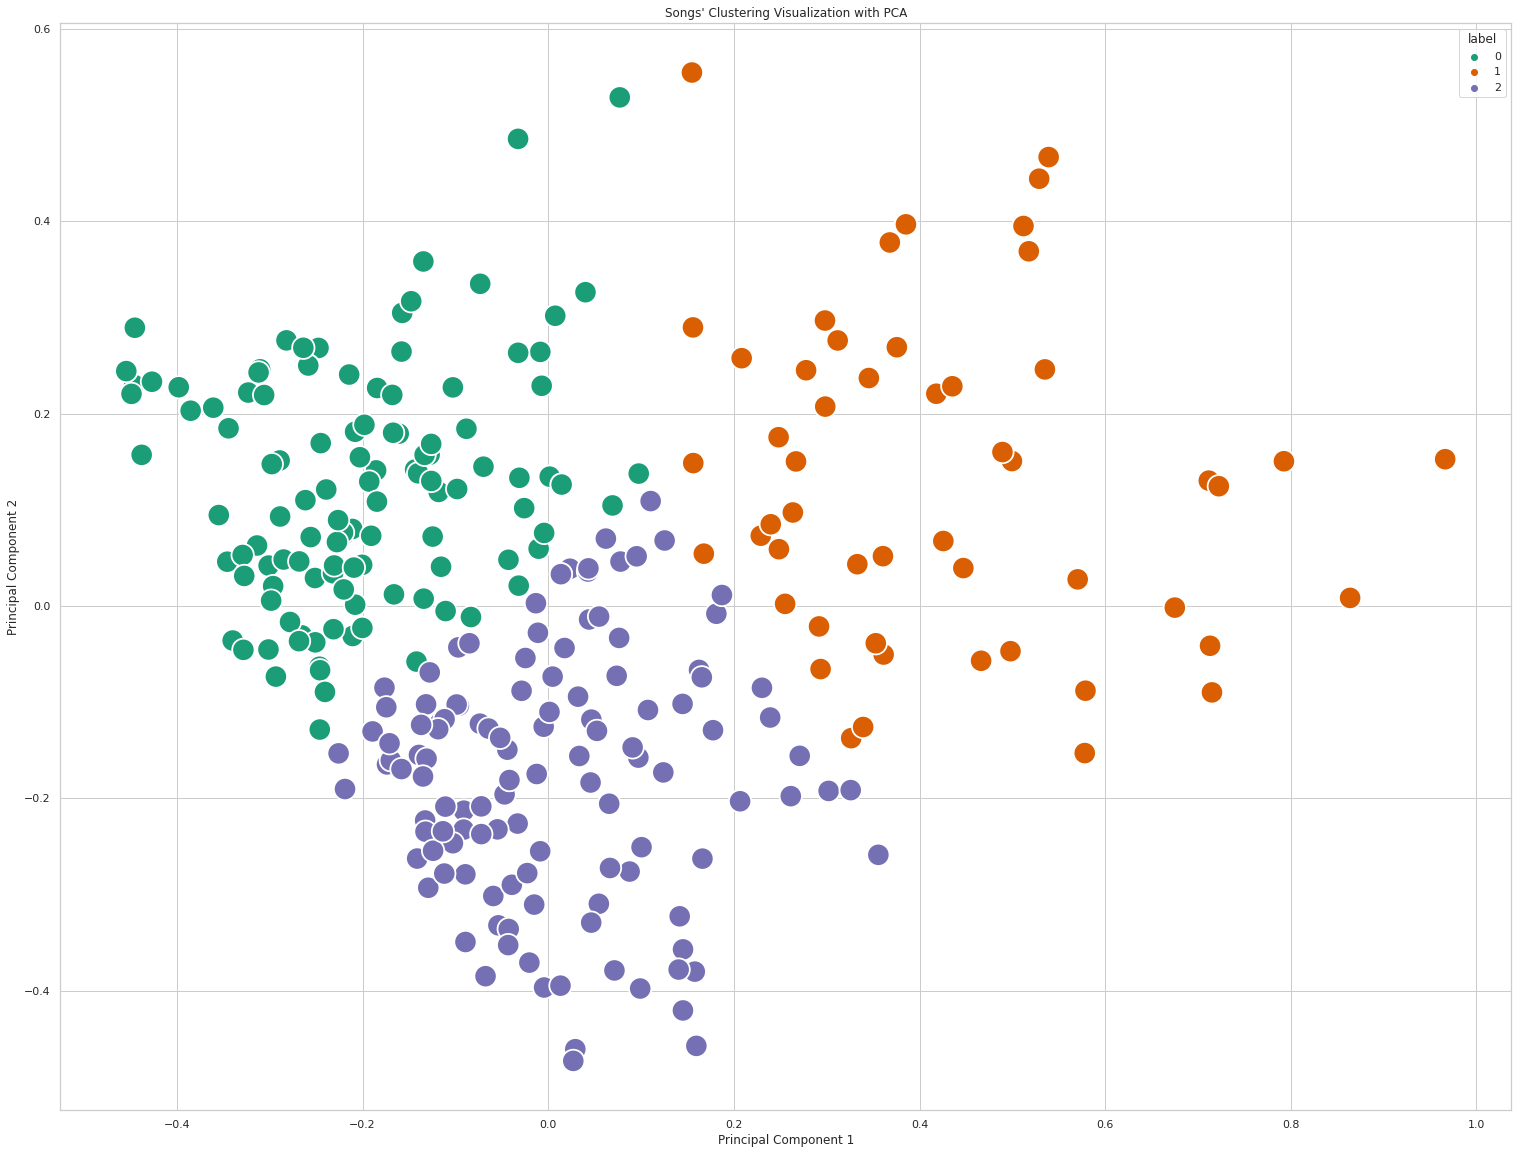

In [164]:
#PCA seeks to preserve large pairwise distances to maximize variance

from sklearn.decomposition import PCA

pca = PCA(n_components=2) #2 dimensions
pc = pca.fit_transform(X) #Fit the model with X and apply the dimensionality reduction on X

#Creating a data frame with the results from the dimensionality reduction (in order to display the data in 2d)
pca_df = pd.DataFrame(pc, columns=['Principal Component 1', 'Principal Component 2']) 
pca_df['label'] = y

sns.scatterplot(data=pca_df, x='Principal Component 1', y='Principal Component 2', hue='label', palette='Dark2',s=500)
plt.title("Songs' Clustering Visualization with PCA")
plt.show()

/home/shubham/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


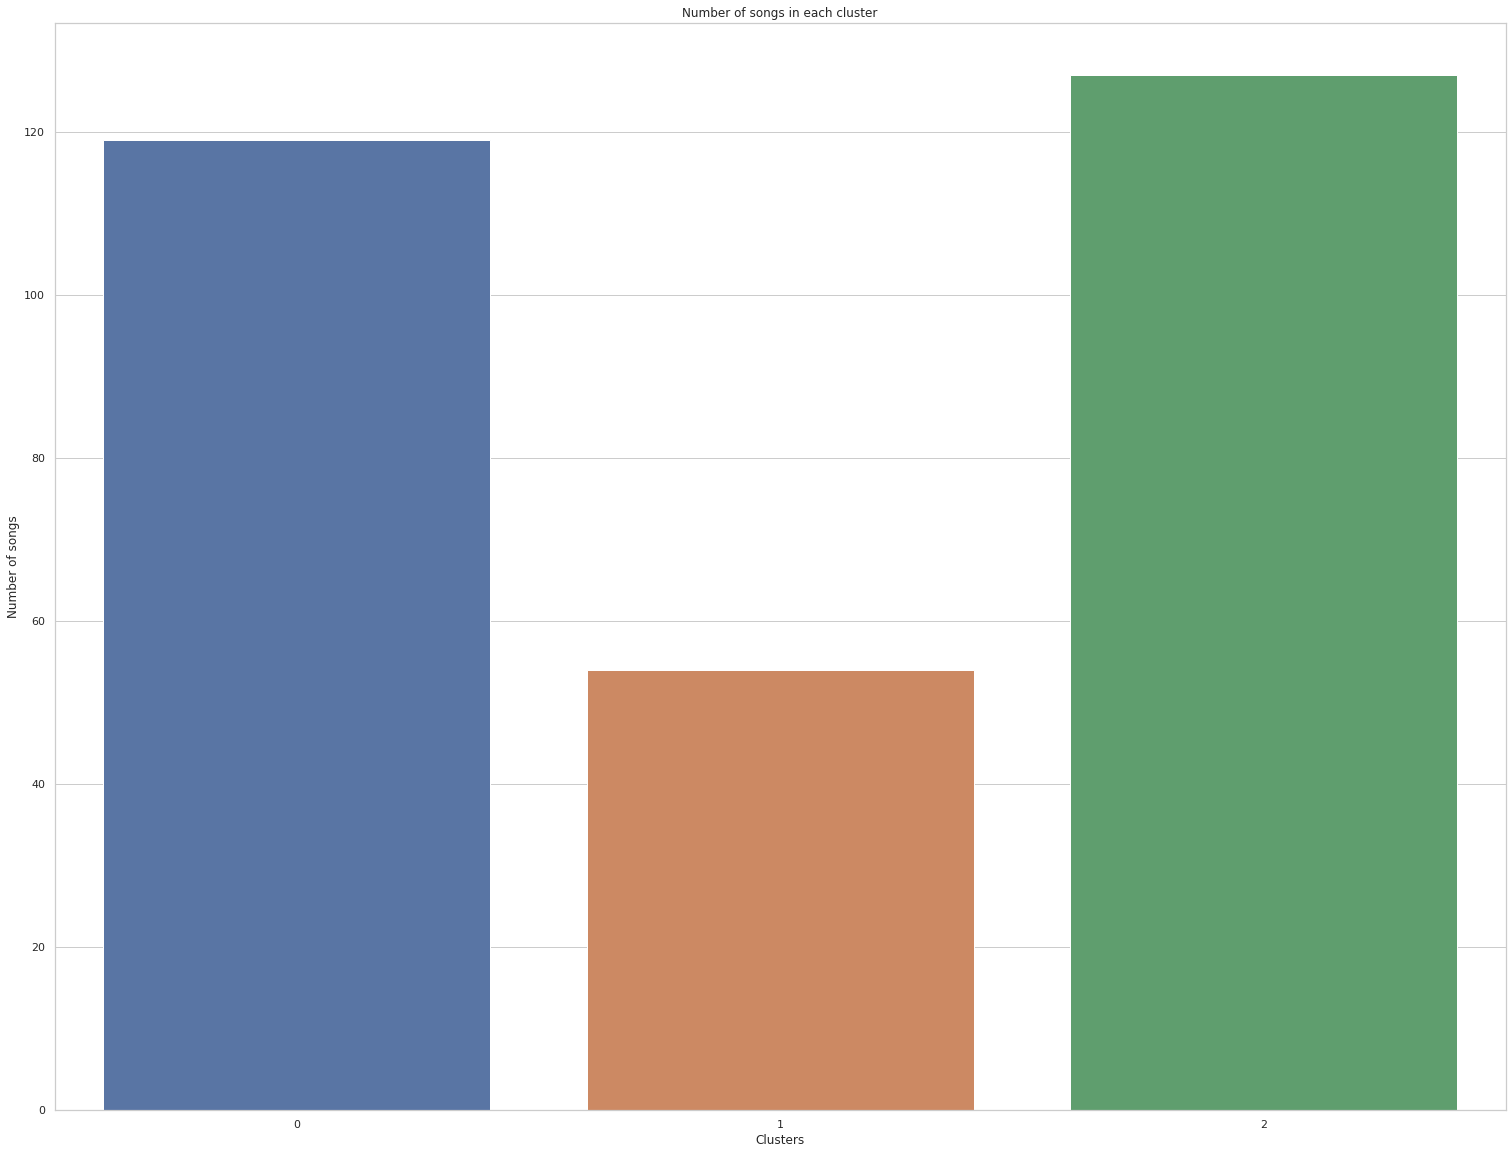

In [165]:
sns.countplot(y)
plt.xlabel('Clusters')
plt.ylabel('Number of songs')
plt.title('Number of songs in each cluster')
plt.show()

In [166]:
#Our data frame now has a target column (indicating the cluster in which each song is grouped)
audio_features_df.loc[:, 'label'] = y
audio_features_df.head(30)

,track,artist,year,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,label
0,Old Town Road (feat. Billy Ray Cyrus) - Remix,Lil Nas X,2019,0.878,0.619,6,-5.560,1,0.1020,0.05330,...,0.639,136.041,audio_features,6u7jPi22kF8CTQ3rb9DHE7,spotify:track:6u7jPi22kF8CTQ3rb9DHE7,https://api.spotify.com/v1/tracks/6u7jPi22kF8C...,https://api.spotify.com/v1/audio-analysis/6u7j...,157067,4,0
1,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,2018,0.760,0.479,2,-5.574,1,0.0466,0.55600,...,0.913,89.911,audio_features,3KkXRkHbMCARz0aVfEt68P,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,158040,4,0
2,Without Me,Halsey,2018,0.752,0.488,6,-7.050,1,0.0705,0.29700,...,0.533,136.041,audio_features,5p7ujcrUXASCNwRaWNHR1C,spotify:track:5p7ujcrUXASCNwRaWNHR1C,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,https://api.spotify.com/v1/audio-analysis/5p7u...,201661,4,2
3,bad guy,Billie Eilish,2019,0.701,0.425,7,-10.965,1,0.3750,0.32800,...,0.562,135.128,audio_features,2Fxmhks0bxGSBdJ92vM42m,spotify:track:2Fxmhks0bxGSBdJ92vM42m,https://api.spotify.com/v1/tracks/2Fxmhks0bxGS...,https://api.spotify.com/v1/audio-analysis/2Fxm...,194088,4,2
4,Wow.,Post Malone,2018,0.833,0.539,11,-7.399,0,0.1780,0.16300,...,0.385,99.947,audio_features,6MWtB6iiXyIwun0YzU6DFP,spotify:track:6MWtB6iiXyIwun0YzU6DFP,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,https://api.spotify.com/v1/audio-analysis/6MWt...,149520,4,2
5,Happier,Marshmello,2018,0.687,0.792,5,-2.749,1,0.0452,0.19100,...,0.671,100.015,audio_features,2dpaYNEQHiRxtZbfNsse99,spotify:track:2dpaYNEQHiRxtZbfNsse99,https://api.spotify.com/v1/tracks/2dpaYNEQHiRx...,https://api.spotify.com/v1/audio-analysis/2dpa...,214290,4,0
6,7 rings,Ariana Grande,2019,0.725,0.321,1,-10.744,0,0.3230,0.57800,...,0.319,70.142,audio_features,14msK75pk3pA33pzPVNtBF,spotify:track:14msK75pk3pA33pzPVNtBF,https://api.spotify.com/v1/tracks/14msK75pk3pA...,https://api.spotify.com/v1/audio-analysis/14ms...,178640,4,1
7,Talk (feat. Disclosure),Khalid,2019,0.900,0.400,0,-8.575,1,0.1270,0.05160,...,0.346,135.984,audio_features,6TqXcAFInzjp0bODyvrWEq,spotify:track:6TqXcAFInzjp0bODyvrWEq,https://api.spotify.com/v1/tracks/6TqXcAFInzjp...,https://api.spotify.com/v1/audio-analysis/6TqX...,197573,4,2
8,SICKO MODE,Travis Scott,2018,0.834,0.730,8,-3.714,1,0.2220,0.00513,...,0.446,155.008,audio_features,2xLMifQCjDGFmkHkpNLD9h,spotify:track:2xLMifQCjDGFmkHkpNLD9h,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,https://api.spotify.com/v1/audio-analysis/2xLM...,312820,4,2
9,Sucker,Jonas Brothers,2019,0.842,0.734,1,-5.065,0,0.0588,0.04270,...,0.952,137.958,audio_features,4y3OI86AEP6PQoDE6olYhO,spotify:track:4y3OI86AEP6PQoDE6olYhO,https://api.spotify.com/v1/tracks/4y3OI86AEP6P...,https://api.spotify.com/v1/audio-analysis/4y3O...,181040,4,0


['6u7jPi22kF8CTQ3rb9DHE7', '3KkXRkHbMCARz0aVfEt68P', '2dpaYNEQHiRxtZbfNsse99', '4y3OI86AEP6PQoDE6olYhO', '1rqqCSm0Qe4I9rUvWncaom', '0TK2YIli7K1leLovkQiNik', '3HVWdVOQ0ZA45FuZGSfvns', '2IRZnDFmlqMuOrYOLnZZyc', '25sgk305KZfyuqVBQIahim', '2gwkD6igEhQbDQegRCcdoB', '6LsAAHotRLMOHfCsSfYCsz', '0PG9fbaaHFHfre2gUVo7AN', '29fRTIKsJhLUJoldM89GZS', '3Ol2xnObFdKV9pmRD2t9x8', '4MsUsFfWseB9M2plGJyuIw', '4evmHXcjt3bTUHD1cvny97', '6foY66mWZN0pSRjZ408c00', '5dW1VZPcFqB4n0P08rGDgm', '4w8niZpiMy6qz1mntFA5uM', '5JEx7HbmvHQQswJCsoo9rA', '05t7JMip6JrLuSrMV5yYjX', '22oEJW6r2rMb9z4IntfyEa', '21jGcNKet2qwijlDFuPiPb', '7nfmK6oHPDlAd68A11d7AN', '4au7FRcgZzChASRYu279xH', '7eBqSVxrzQZtK2mmgRG6lC', '58q2HKrzhC3ozto2nDdN4z', '14mHfNsSHN0FbLftyjrV9g', '5nzhL67GpF9szXWg5y509A', '5ygDXis42ncn6kYG14lEVG', '6nxcOGl5E292RUh7iR7KTW', '0DiDStADDVh3SvAsoJAFMk', '6ERR6e7h6wCqGoz1TjiUJb', '2KqJC0koTBUyDlsMt5ok1V', '1D07CwYBPqu8NbQTdu9C1g', '2rMAtCaTj16NptyVfEIeAC', '5N1o6d8zGcSZSeMFkOUQOk', '0uSGTaHms9ceAxb7L6VLrU', '0Ryd8975Wi

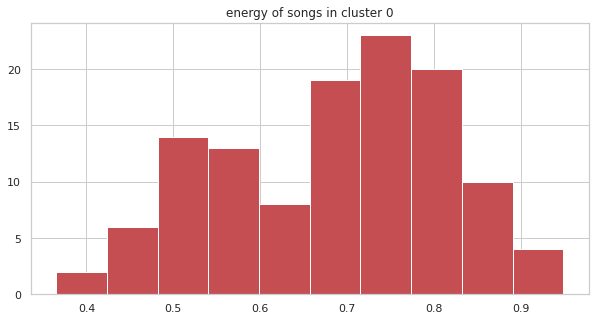

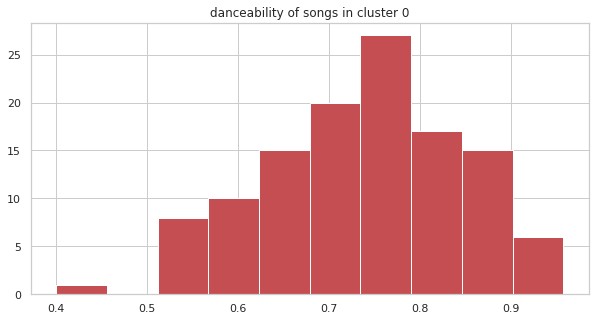

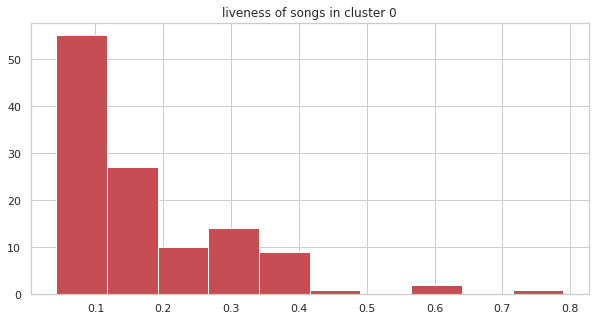

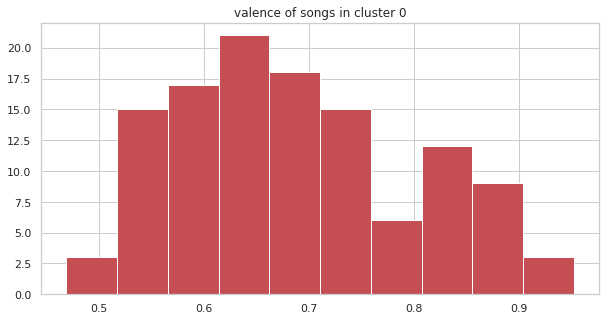

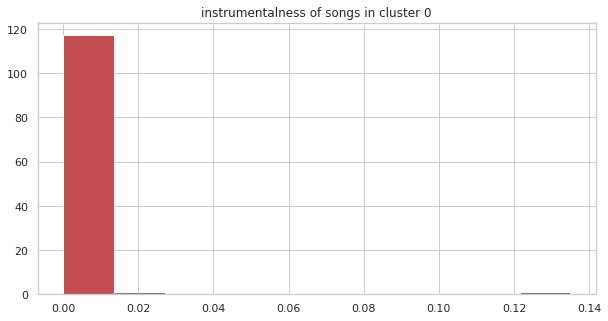

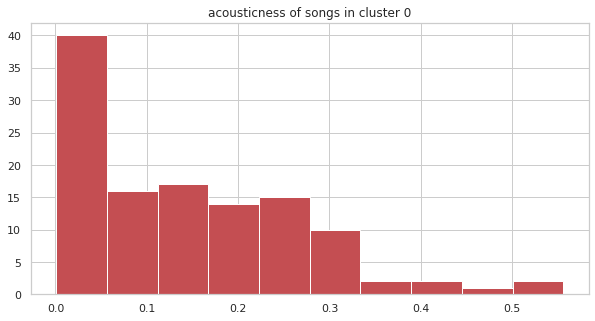

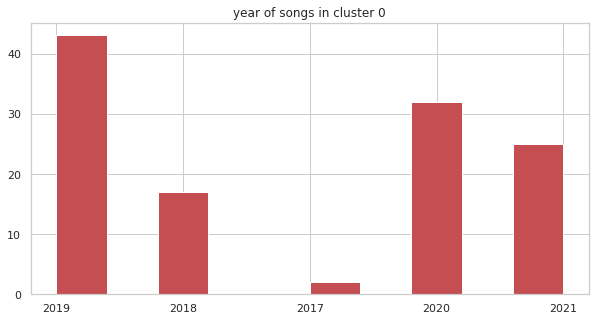

In [167]:
l0 = []
l1 = []
l2 = []
l3 = []
for k,v in enumerate(audio_features_df['id']):
    if y[k] == 0:
        l0.append(v)
    elif y[k] == 1:
        l1.append(v)
    elif y[k] == 2:
        l2.append(v)
    else:
        l3.append(v)
        
        
print(l0) #cluster 0
for feature in features:
    plt.subplot(audio_features_df.loc[:,feature][audio_features_df['label'] == 0].hist(color='r', figsize=(10,5)))
    plt.title("%s of songs in cluster 0" % feature)
    plt.show()

plt.subplot(audio_features_df.loc[:,"year"][audio_features_df['label'] == 0].hist(color='r', figsize=(10,5)))
plt.title("year of songs in cluster 0" )
plt.show()

mean_cluster0 = audio_features_df.loc[:,features][audio_features_df['label'] == 0].mean()

['14msK75pk3pA33pzPVNtBF', '6Qs4SXO9dwPj5GKvVOv8Ki', '0d2iYfpKoM0QCKvcLCkBao', '2VxeLyX666F8uXCJ0dZF8B', '6FRLCMO5TUHTexlWo8ym1W', '7qEHsqek33rTcFNT9PFqLf', '6vBdBCoOhKHiYDDOcorfNo', '2rxQMGVafnNaRaXlRMWPde', '3EPXxR3ImUwfayaurPi3cm', '6Up545NUflOiXo8cEraH49', '43zdsphuZLzwA9k4DJhU0I', '0lsRatBUs9HNIZAmoGABzk', '4SSnFejRGlZikf02HLewEF', '4XiGKQqbmnMVxDzUj6j3f2', '56eGOeSsqdg3FLxdo83TwV', '4qQwGRtGT7l6ckQtdPEFd4', '2b8fOow8UzyDFAE27YhOZM', '7qEHsqek33rTcFNT9PFqLf', '1rgnBhdG2JDFTbYkYRZAku', '3ZCTVFBt2Brf31RLEnCkWJ', '2gMXnyrvIjhVBUZwvLZDMP', '4l0Mvzj72xxOpRrp6h8nHi', '5MwynWK9s4hlyKHqhkNn4A', '7eJMfftS33KTjuF7lTsMCx', '0lsRatBUs9HNIZAmoGABzk', '2kJwzbxV2ppxnQoYw4GLBZ', '7cA3PnUQDlUyBBwpRozQeo', '4TCc369aRPRubv1m8R1TBG', '5RqR4ZCCKJDcBLIn4sih9l', '4S2uhQE8L9V6p7rj7SiauJ', '5rZlwNFl01HqLWBQGryKSm', '30RZAuEkYeDXvy46Iv6l7E', '48KXAIruJ07kJVCWOGohMV', '0eBXyY4SatzpE7opnzgXvz', '5wANPM4fQCJwkGd4rN57mH', '6HU7h9RYOaPRFeh0R3UeAr', '02MWAaffLxlfxAUY7c5dvx', '1tkg4EHVoqnhR6iFEXb60y', '43PGPuHIlV

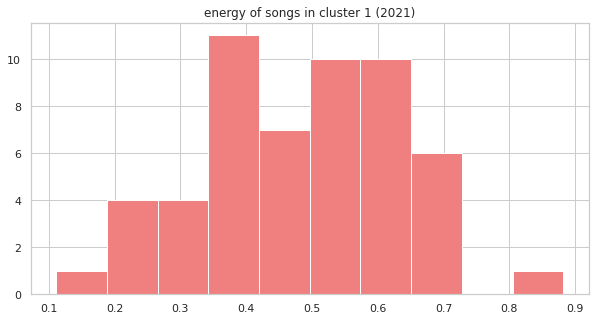

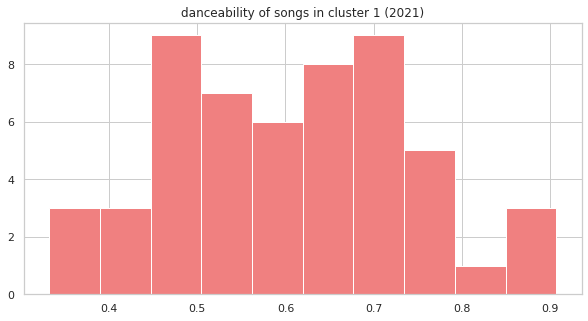

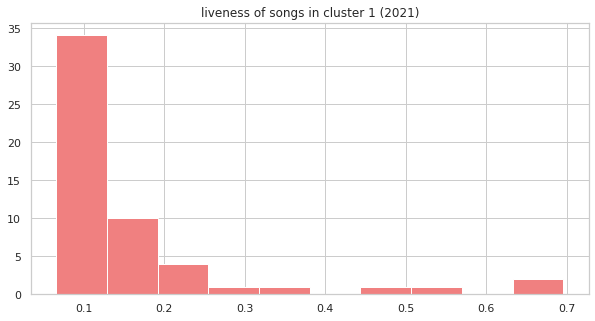

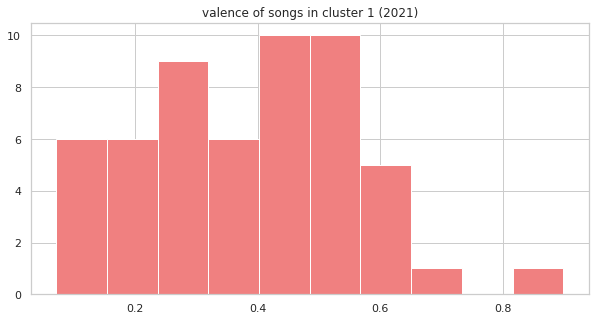

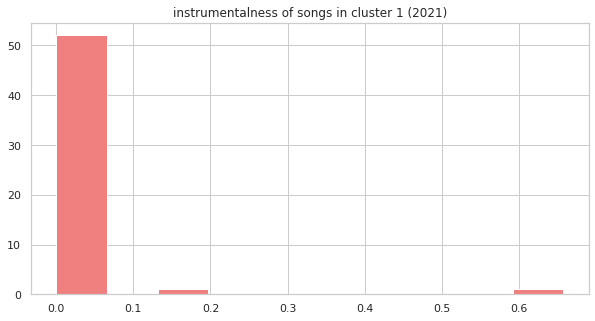

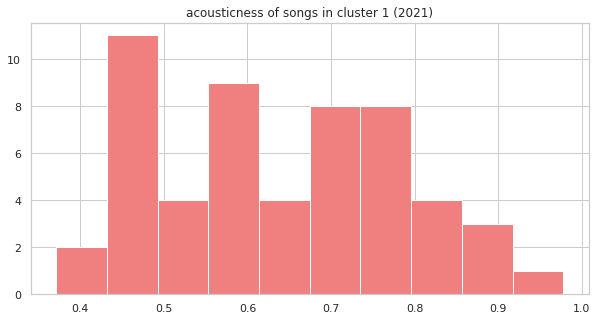

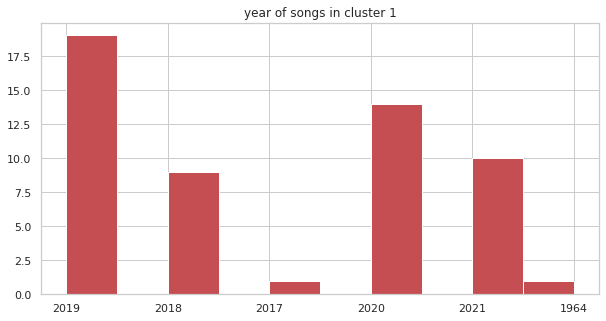

In [168]:
print(l1) #cluster 1
for feature in features:
    plt.subplot(audio_features_df.loc[:,feature][audio_features_df['label'] == 1].hist(color='lightcoral',
                                                                                       figsize=(10,5)))
    plt.title("%s of songs in cluster 1 (2021)" % feature)
    plt.show()

plt.subplot(audio_features_df.loc[:,"year"][audio_features_df['label'] == 1].hist(color='r', figsize=(10,5)))
plt.title("year of songs in cluster 1" )
plt.show()

mean_cluster1 = audio_features_df.loc[:,features][audio_features_df['label'] == 1].mean()

['5p7ujcrUXASCNwRaWNHR1C', '2Fxmhks0bxGSBdJ92vM42m', '6MWtB6iiXyIwun0YzU6DFP', '6TqXcAFInzjp0bODyvrWEq', '2xLMifQCjDGFmkHkpNLD9h', '2rPE9A1vEgShuZxxzR2tZH', '5qmq61DAAOUaW8AUo8xKhh', '4T3fNx3CgwDRRYgmFCbD4J', '7FEwp8BavoEVE3AnxJDchc', '2JvzF1RMd7lE3KmFlsyZD8', '78QR3Wp35dqAhFEc2qAGjE', '1kBbgxAUc4HQv7cgIayIDH', '0FZ4Dmg8jJJAPJnvBIzD9z', '7dt6x5M1jzdTEt8oCbisTK', '2iUXsYOEPhVqEBwsqP70rE', '5ry2OE6R2zPQFDO85XkgRb', '7q7jyVU0f0hnod8tsaUmxg', '4kV4N9D1iKVxx1KLvtTpjS', '2GGMabyHXnJmjY6CXhhB2e', '6fTt0CH2t0mdeB2N9XFG5r', '2t8yVaLvJ0RenpXUIAC52d', '116H0KvKr2Zl4RPuVBruDO', '5AjINjwKyRvQJhSe2zpPHi', '3oh6SCCeLuXhFpEyepla6G', '285pBltuF7vW8TeWk8hdRR', '1xzBco0xcoJEDXktl7Jxrr', '0QIjsbm2fh1cJ45XO9eGqq', '1dyxS3YzBbL0t8rEVwVQ1K', '63cd4JkwGgYJrbOizbfmsp', '7DcvwMAiqKJQD1rrdfxSDx', '3A2yGHWIzmGEIolwonU69h', '4OafepJy2teCjYJbvFE60J', '6CTWathupIiDs7U4InHnDA', '1wJRveJZLSb1rjhnUHQiv6', '6b2RcmUt1g9N9mQ3CbjX2Y', '5MPPttjfGap2C6j6eKcO6J', '59ywHNwwchG4nZJMLyxSzd', '45Egmo7icyopuzJN0oMEdk', '4hPpVbbakQ

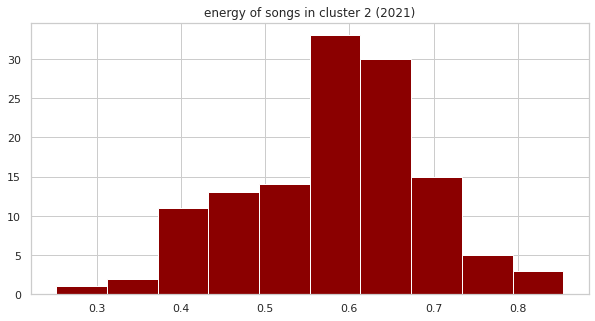

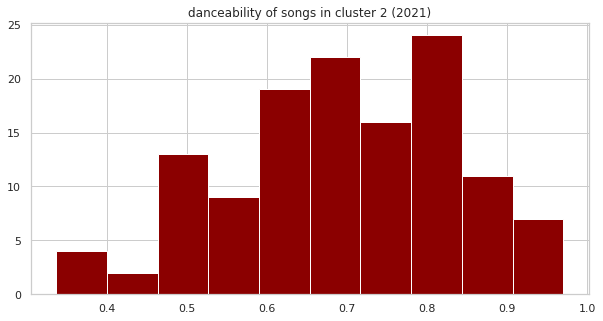

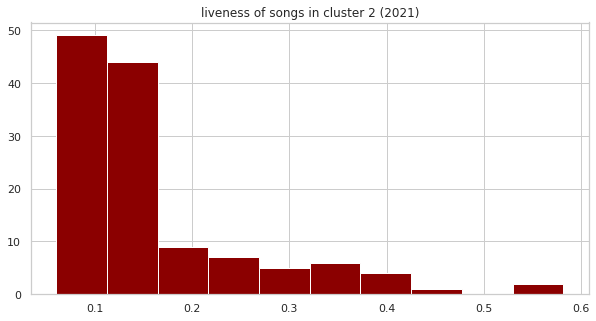

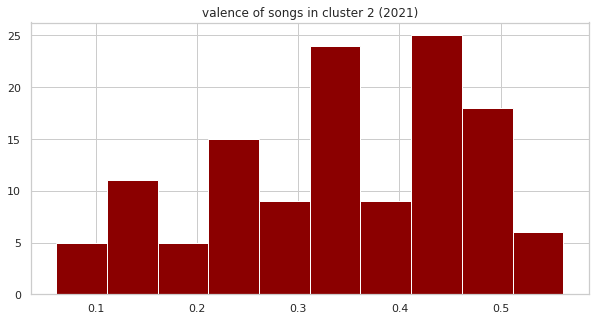

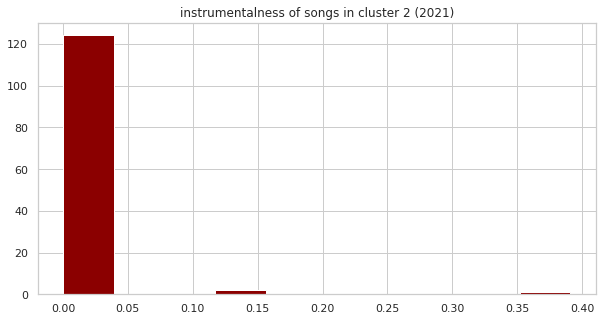

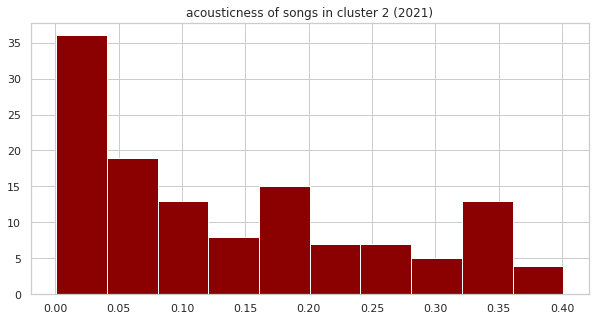

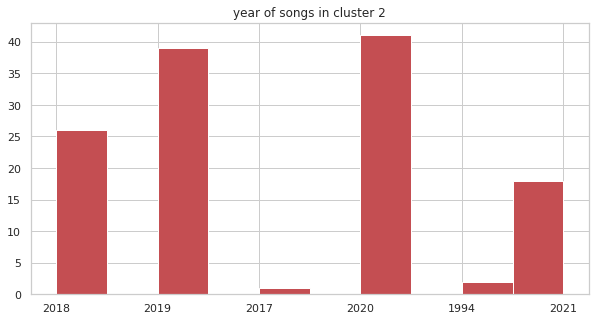

In [169]:
print(l2) #cluster 2
for feature in features:
    plt.subplot(audio_features_df.loc[:,feature][audio_features_df['label'] == 2].hist(color='darkred',
                                                                                       figsize=(10,5)))
    plt.title("%s of songs in cluster 2 (2021)" % feature)
    plt.show()
    
plt.subplot(audio_features_df.loc[:,"year"][audio_features_df['label'] == 2].hist(color='r', figsize=(10,5)))
plt.title("year of songs in cluster 2" )
plt.show()

mean_cluster2 = audio_features_df.loc[:,features][audio_features_df['label'] == 2].mean()

[]


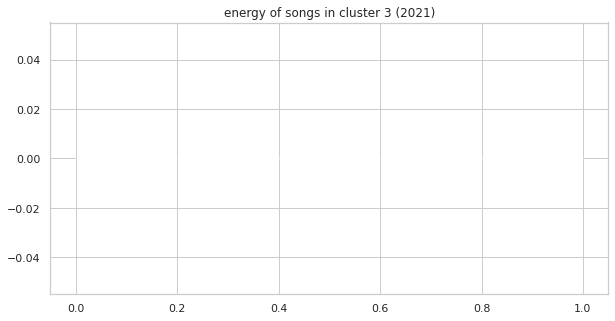

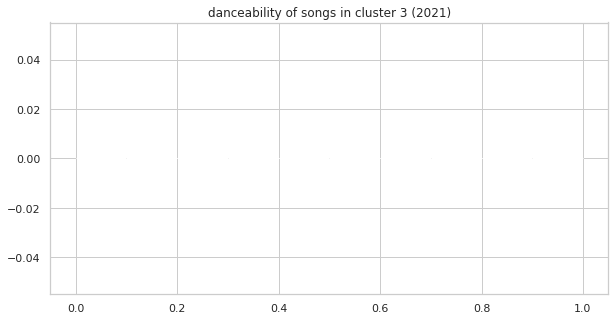

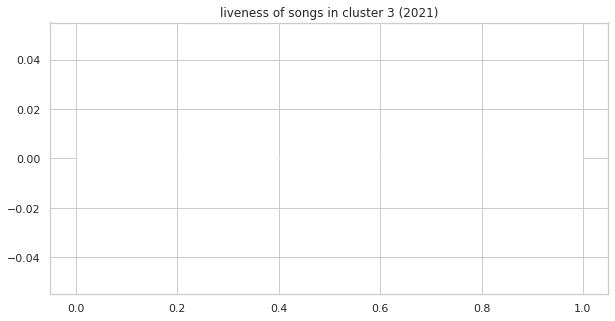

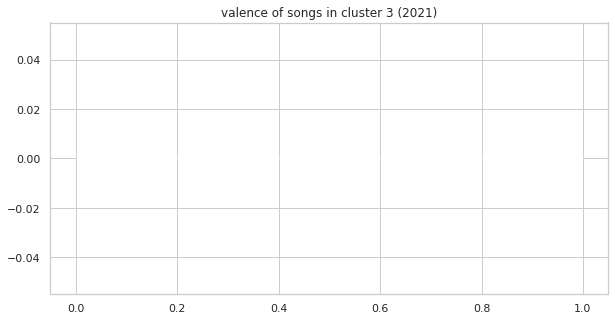

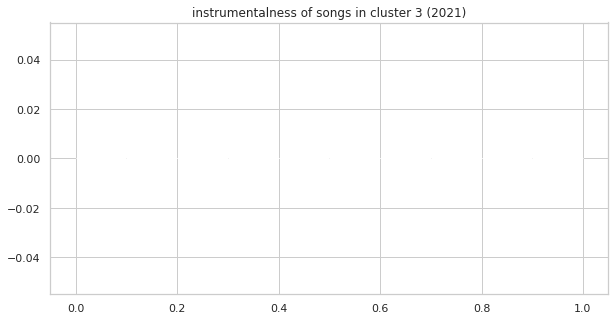

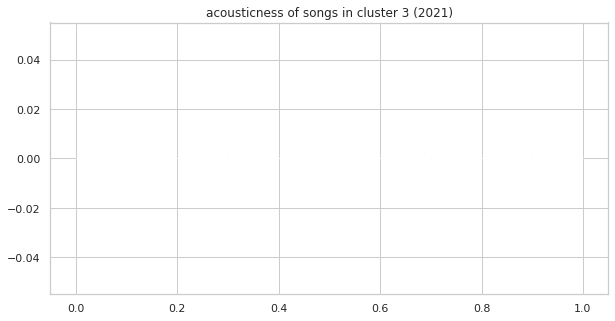

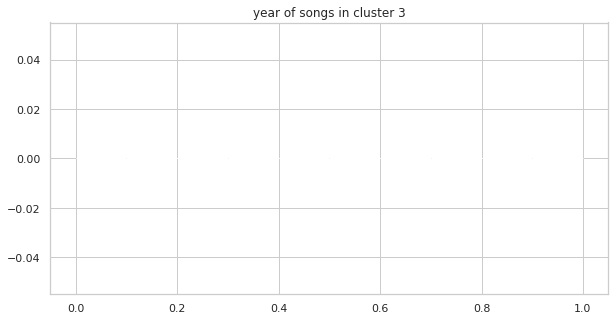

In [170]:
print(l3) #cluster 3
for feature in features:
    plt.subplot(audio_features_df.loc[:,feature][audio_features_df['label'] == 3].hist(color='firebrick',
                                                                                       figsize=(10,5)))
    plt.title("%s of songs in cluster 3 (2021)" % feature)
    plt.show()

plt.subplot(audio_features_df.loc[:,"year"][audio_features_df['label'] == 3].hist(color='r', figsize=(10,5)))
plt.title("year of songs in cluster 3" )
plt.show()
    
mean_cluster3 = audio_features_df.loc[:,features][audio_features_df['label'] == 3].mean()

In [171]:
mean_df = pd.DataFrame(mean_cluster0, columns=['Cluster 0'])
mean_df['Cluster 1'] = mean_cluster1
mean_df['Cluster 2'] = mean_cluster2
mean_df['Cluster 3'] = mean_cluster3
mean_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
energy,0.686546,0.481370,0.584362,NaN
danceability,0.733857,0.608593,0.695559,NaN
liveness,0.177001,0.160554,0.163713,NaN
valence,0.687261,0.384289,0.341061,NaN
instrumentalness,0.001481,0.015303,0.005565,NaN
acousticness,0.142557,0.635389,0.137737,NaN


Insights:
- Cluster 0 is suitable for dancing, many songs are acoustic and they tend to be slow
- Cluster 1 has, majorly, fast/noisy songs and they don't tend to be cheerful
- Cluster 2 is the most suitable for dancing, many tracks are loud/noisy and they don't tend to cheerful
- Cluster 3 is suitable for dancing, tracks are majorly cheerful and loud/noisy

In [172]:
audio_features_df.loc[audio_features_df['label'] == 0]

,track,artist,year,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,label
0,Old Town Road (feat. Billy Ray Cyrus) - Remix,Lil Nas X,2019,0.878,0.619,6,-5.560,1,0.1020,0.0533,...,0.639,136.041,audio_features,6u7jPi22kF8CTQ3rb9DHE7,spotify:track:6u7jPi22kF8CTQ3rb9DHE7,https://api.spotify.com/v1/tracks/6u7jPi22kF8C...,https://api.spotify.com/v1/audio-analysis/6u7j...,157067,4,0
1,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,2018,0.760,0.479,2,-5.574,1,0.0466,0.5560,...,0.913,89.911,audio_features,3KkXRkHbMCARz0aVfEt68P,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,158040,4,0
5,Happier,Marshmello,2018,0.687,0.792,5,-2.749,1,0.0452,0.1910,...,0.671,100.015,audio_features,2dpaYNEQHiRxtZbfNsse99,spotify:track:2dpaYNEQHiRxtZbfNsse99,https://api.spotify.com/v1/tracks/2dpaYNEQHiRx...,https://api.spotify.com/v1/audio-analysis/2dpa...,214290,4,0
9,Sucker,Jonas Brothers,2019,0.842,0.734,1,-5.065,0,0.0588,0.0427,...,0.952,137.958,audio_features,4y3OI86AEP6PQoDE6olYhO,spotify:track:4y3OI86AEP6PQoDE6olYhO,https://api.spotify.com/v1/tracks/4y3OI86AEP6P...,https://api.spotify.com/v1/audio-analysis/4y3O...,181040,4,0
10,High Hopes,Panic! At The Disco,2018,0.579,0.904,5,-2.729,1,0.0618,0.1930,...,0.681,82.014,audio_features,1rqqCSm0Qe4I9rUvWncaom,spotify:track:1rqqCSm0Qe4I9rUvWncaom,https://api.spotify.com/v1/tracks/1rqqCSm0Qe4I...,https://api.spotify.com/v1/audio-analysis/1rqq...,190947,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,Take My Breath - Single Version,The Weeknd,2021,0.748,0.740,8,-6.010,1,0.0484,0.0107,...,0.518,121.004,audio_features,6OGogr19zPTM4BALXuMQpF,spotify:track:6OGogr19zPTM4BALXuMQpF,https://api.spotify.com/v1/tracks/6OGogr19zPTM...,https://api.spotify.com/v1/audio-analysis/6OGo...,220196,4,0
289,We're Good,Dua Lipa,2021,0.722,0.588,6,-5.932,1,0.0544,0.0319,...,0.590,134.010,audio_features,1diS6nkxMQc3wwC4G1j0bh,spotify:track:1diS6nkxMQc3wwC4G1j0bh,https://api.spotify.com/v1/tracks/1diS6nkxMQc3...,https://api.spotify.com/v1/audio-analysis/1diS...,165507,4,0
290,Hell Of A View,Eric Church,2020,0.689,0.582,5,-6.778,1,0.0236,0.1190,...,0.883,99.021,audio_features,1kBx9VGumfuvlfqdlAGorE,spotify:track:1kBx9VGumfuvlfqdlAGorE,https://api.spotify.com/v1/tracks/1kBx9VGumfuv...,https://api.spotify.com/v1/audio-analysis/1kBx...,175280,4,0
294,Single Saturday Night,Cole Swindell,2020,0.623,0.790,7,-5.070,1,0.0473,0.1180,...,0.694,81.949,audio_features,1irAliF0T8sLIOPJp6n7rU,spotify:track:1irAliF0T8sLIOPJp6n7rU,https://api.spotify.com/v1/tracks/1irAliF0T8sL...,https://api.spotify.com/v1/audio-analysis/1irA...,187684,4,0


In [173]:
audio_features_df.loc[audio_features_df['label'] == 1]

,track,artist,year,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,label
6,7 rings,Ariana Grande,2019,0.725,0.321,1,-10.744,0,0.3230,0.578,...,0.3190,70.142,audio_features,14msK75pk3pA33pzPVNtBF,spotify:track:14msK75pk3pA33pzPVNtBF,https://api.spotify.com/v1/tracks/14msK75pk3pA...,https://api.spotify.com/v1/audio-analysis/14ms...,178640,4,1
13,Dancing With A Stranger (with Normani),Sam Smith,2019,0.741,0.520,8,-7.513,1,0.0656,0.450,...,0.3470,102.998,audio_features,6Qs4SXO9dwPj5GKvVOv8Ki,spotify:track:6Qs4SXO9dwPj5GKvVOv8Ki,https://api.spotify.com/v1/tracks/6Qs4SXO9dwPj...,https://api.spotify.com/v1/audio-analysis/6Qs4...,171030,4,1
16,Eastside (with Halsey & Khalid),benny blanco,2018,0.560,0.680,6,-7.648,0,0.3210,0.555,...,0.3190,89.391,audio_features,0d2iYfpKoM0QCKvcLCkBao,spotify:track:0d2iYfpKoM0QCKvcLCkBao,https://api.spotify.com/v1/tracks/0d2iYfpKoM0Q...,https://api.spotify.com/v1/audio-analysis/0d2i...,173800,4,1
18,Shallow,Lady Gaga,2018,0.572,0.385,7,-6.362,1,0.0308,0.371,...,0.3230,95.799,audio_features,2VxeLyX666F8uXCJ0dZF8B,spotify:track:2VxeLyX666F8uXCJ0dZF8B,https://api.spotify.com/v1/tracks/2VxeLyX666F8...,https://api.spotify.com/v1/audio-analysis/2Vxe...,215733,4,1
21,Girls Like You (feat. Cardi B) - Cardi B Version,Maroon 5,2018,0.851,0.541,0,-6.825,1,0.0505,0.568,...,0.4480,124.959,audio_features,6FRLCMO5TUHTexlWo8ym1W,spotify:track:6FRLCMO5TUHTexlWo8ym1W,https://api.spotify.com/v1/tracks/6FRLCMO5TUHT...,https://api.spotify.com/v1/audio-analysis/6FRL...,235545,4,1
26,Someone You Loved,Lewis Capaldi,2019,0.501,0.405,1,-5.679,1,0.0319,0.751,...,0.4460,109.891,audio_features,7qEHsqek33rTcFNT9PFqLf,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,https://api.spotify.com/v1/audio-analysis/7qEH...,182161,4,1
29,Goodbyes (Feat. Young Thug),Post Malone,2019,0.580,0.653,5,-3.818,1,0.0745,0.447,...,0.1750,150.231,audio_features,6vBdBCoOhKHiYDDOcorfNo,spotify:track:6vBdBCoOhKHiYDDOcorfNo,https://api.spotify.com/v1/tracks/6vBdBCoOhKHi...,https://api.spotify.com/v1/audio-analysis/6vBd...,174960,4,1
45,Beautiful Crazy,Luke Combs,2018,0.551,0.402,11,-7.431,1,0.0262,0.676,...,0.3820,103.313,audio_features,2rxQMGVafnNaRaXlRMWPde,spotify:track:2rxQMGVafnNaRaXlRMWPde,https://api.spotify.com/v1/tracks/2rxQMGVafnNa...,https://api.spotify.com/v1/audio-analysis/2rxQ...,193200,4,1
53,Be Alright,Dean Lewis,2018,0.553,0.586,11,-6.319,1,0.0362,0.697,...,0.4430,126.684,audio_features,3EPXxR3ImUwfayaurPi3cm,spotify:track:3EPXxR3ImUwfayaurPi3cm,https://api.spotify.com/v1/tracks/3EPXxR3ImUwf...,https://api.spotify.com/v1/audio-analysis/3EPX...,196373,4,1
59,You Say,Lauren Daigle,2018,0.494,0.632,5,-6.890,1,0.0342,0.682,...,0.0797,147.873,audio_features,6Up545NUflOiXo8cEraH49,spotify:track:6Up545NUflOiXo8cEraH49,https://api.spotify.com/v1/tracks/6Up545NUflOi...,https://api.spotify.com/v1/audio-analysis/6Up5...,274693,4,1


In [174]:
audio_features_df.loc[audio_features_df['label'] == 2]

,track,artist,year,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,label
2,Without Me,Halsey,2018,0.752,0.488,6,-7.050,1,0.0705,0.29700,...,0.533,136.041,audio_features,5p7ujcrUXASCNwRaWNHR1C,spotify:track:5p7ujcrUXASCNwRaWNHR1C,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,https://api.spotify.com/v1/audio-analysis/5p7u...,201661,4,2
3,bad guy,Billie Eilish,2019,0.701,0.425,7,-10.965,1,0.3750,0.32800,...,0.562,135.128,audio_features,2Fxmhks0bxGSBdJ92vM42m,spotify:track:2Fxmhks0bxGSBdJ92vM42m,https://api.spotify.com/v1/tracks/2Fxmhks0bxGS...,https://api.spotify.com/v1/audio-analysis/2Fxm...,194088,4,2
4,Wow.,Post Malone,2018,0.833,0.539,11,-7.399,0,0.1780,0.16300,...,0.385,99.947,audio_features,6MWtB6iiXyIwun0YzU6DFP,spotify:track:6MWtB6iiXyIwun0YzU6DFP,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,https://api.spotify.com/v1/audio-analysis/6MWt...,149520,4,2
7,Talk (feat. Disclosure),Khalid,2019,0.900,0.400,0,-8.575,1,0.1270,0.05160,...,0.346,135.984,audio_features,6TqXcAFInzjp0bODyvrWEq,spotify:track:6TqXcAFInzjp0bODyvrWEq,https://api.spotify.com/v1/tracks/6TqXcAFInzjp...,https://api.spotify.com/v1/audio-analysis/6TqX...,197573,4,2
8,SICKO MODE,Travis Scott,2018,0.834,0.730,8,-3.714,1,0.2220,0.00513,...,0.446,155.008,audio_features,2xLMifQCjDGFmkHkpNLD9h,spotify:track:2xLMifQCjDGFmkHkpNLD9h,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,https://api.spotify.com/v1/audio-analysis/2xLM...,312820,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,Knife Talk (with 21 Savage ft. Project Pat),Drake,2021,0.849,0.424,5,-9.579,0,0.3240,0.06350,...,0.153,145.887,audio_features,2BcMwX1MPV6ZHP4tUT9uq6,spotify:track:2BcMwX1MPV6ZHP4tUT9uq6,https://api.spotify.com/v1/tracks/2BcMwX1MPV6Z...,https://api.spotify.com/v1/audio-analysis/2BcM...,242966,4,2
286,pov,Ariana Grande,2020,0.487,0.534,0,-5.664,0,0.0555,0.36000,...,0.173,131.798,audio_features,3UoULw70kMsiVXxW0L3A33,spotify:track:3UoULw70kMsiVXxW0L3A33,https://api.spotify.com/v1/tracks/3UoULw70kMsi...,https://api.spotify.com/v1/audio-analysis/3UoU...,201882,4,2
292,Put Your Records On,Ritt Momney,2020,0.399,0.491,6,-10.778,0,0.0538,0.05630,...,0.151,91.066,audio_features,6AGOKlMZWLCaEJGnaROtF9,spotify:track:6AGOKlMZWLCaEJGnaROtF9,https://api.spotify.com/v1/tracks/6AGOKlMZWLCa...,https://api.spotify.com/v1/audio-analysis/6AGO...,210463,4,2
296,Throat Baby (Go Baby),BRS Kash,2020,0.900,0.521,4,-7.286,0,0.1470,0.01350,...,0.213,132.007,audio_features,31iqpzg1ZXLLgq0L5iIwLe,spotify:track:31iqpzg1ZXLLgq0L5iIwLe,https://api.spotify.com/v1/tracks/31iqpzg1ZXLL...,https://api.spotify.com/v1/audio-analysis/31iq...,218182,4,2


In [175]:
audio_features_df.loc[audio_features_df['label'] == 3]

,track,artist,year,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,label
